In [1]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string
import xml.etree.ElementTree as et

# Vermont

## Load VEST File

In [2]:
vest_vt_20 = gp.read_file("./raw-from-source/VEST/vt_2020/vt_2020.shp")

<AxesSubplot:>

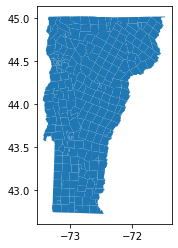

In [3]:
vest_vt_20.plot()

In [4]:
print(vest_vt_20)

    STATEFP20 COUNTYFP20                   NAME20  G20PREDBID  G20PRERTRU  \
0          50        001                  Whiting         124          84   
1          50        001                New Haven         732         396   
2          50        001                Salisbury         393         258   
3          50        001                   Orwell         367         351   
4          50        001              Ferrisburgh        1202         561   
..        ...        ...                      ...         ...         ...   
279        50        019         Troy - Orleans 2          98         115   
280        50        025            Westminster 4        1244         403   
281        50        025            Westminster 3          59          26   
282        50        025   Whitingham - Windham 6         372         319   
283        50        025  Whitingham - Bennington          25          21   

     G20PRELJOR  G20PREGHAW  G20PREIWES  G20PREOOTH  G20PREOSAN  ...  \
0  

## Election Results

### VEST Documentation

Election results from the Vermont Secretary of State (https://electionarchive.vermont.gov/)  


Vermont has four unorganized towns whose residents cast votes in neighboring towns. These were distributed back based on voting age population in the 2019 American Community Survey as 2020 Census results are not yet available at the township level. (Averill-Canaan, Buel's Gore-Huntington, Ferdinand-Brighton, Glastenbury-Shaftsbury.)

G20PREDBID - Joseph R. Biden (Democratic Party)
G20PRERTRU - Donald J. Trump (Republican Party)
G20PRELJOR - Jo Jorgensen (Libertarian Party)
G20PREGHAW - Howie Hawkins (Green Party)
G20PREIWES - Kanye West (Independent)
G20PREOOTH - Other Candidates on Ballot
G20PREOSAN - Bernie Sanders (Write-in)
G20PREOWRI - Other Write-in Candidates

G20HALDWEL - Peter Welch (Democratic Party)
G20HALDRBE - Miriam Berry (Republican Party)
G20HALCHEL - Christopher Helali (Communisty Party)
G20HALIBEC - Peter R. Becker (Independent)
G20HALIHOR - Marcia Horne (Independent)
G20HALIORR - Shawn Orr (Independent)
G20HALITRU - Jerry Trudell (Independent)
G20HALOWRI - Write-in Votes

G20GOVDZUC - David Zuckerman (Progressive Party and Democratic Party (fusion candidate))
G20GOVRSCO - Phil Scott (Republican Party)
G20GOVIHOY - Kevin Hoyt (Independent)
G20GOVTPEY - Emily Peyton (Truth Matters Pary)
G20GOVIWHI - Erynn Hazlett Whitney (Independent)
G20GOVIBIL - Wayne Billado III (Independent)
G20GOVIDEV - Michael Devost (Independent)
G20GOVUDIC - Charly Dickerson (Unaffiliated)
G20GOVOWRI - Write-in Votes

G20LTGDGRA - Molly Gray (Democratic Party)
G20LTGRMIL - Scott Milne (Republican Party)
G20LTGPERI - Cris Ericson (Progressive Party)
G20LTGIBIL - Wayne Billado III (Independent)
G20LTGBCOR - Ralph Corbo (Banigh the F-35s Party)
G20LTGOWRI - Write-in Votes

G20ATGDDON - T.J. Donovan (Democratic Party)
G20ATGRPAI - H. Brooke Paige (Republican Party)
G20ATGPERI - Cris Ericson (Progressive Party)
G20ATGOWRI - Write-in Votes

G20SOSDCON - Jim Condos (Democratic Party)
G20SOSRPAI - H. Brooke Paige (Republican Party)
G20SOSPERI - Cris Ericson (Progressive Party)
G20SOSISMI - Pamala Smith (Independent)
G20SOSOWRI - Write-in Votes

G20TREDPEA - Beth Pearce (Democratic Party)
G20TRERBRA - Barolyn Whitney Branagan (Republican Party)
G20TREPERI - Cris Ericson (Progressive Party)
G20TREIWRI - Alex Wright (Independent)
G20TREOWRI - Write-in Votes

G20AUDOHOF - Doug Hoffer (Democratic Party and Republican Party (fusion candidate))
G20AUDPERI - Cris Ericson (Progressive Party)
G20AUDOWRI - Write-in Votes

### Load Source Files

In [5]:
all_files = os.listdir("./raw-from-source/Election_Results/")
li = []
for file in all_files:
    if file  != ".DS_Store":
        ref = "./raw-from-source/Election_Results/"
        file_ref = ref+file
        file_prev = pd.read_csv(file_ref,engine='python',index_col=None)
        #Only keep the City/Town and Pct columns in one file, as they are duplicated
        #Delete unused columns in others
        if file != 'VT_Elections_Database__2020_Treasurer_General_Election_including_precincts.csv':
            file_prev = file_prev.drop(['City/Town', 'Ward', 'Pct','Blanks', 'Spoiled','Total Votes Cast'], axis=1)
            file_prev = file_prev.drop([0])
        else:
            file_prev = file_prev.drop(['Ward','Blanks', 'Spoiled','Total Votes Cast'], axis=1)
            file_prev = file_prev.drop([0])
        for col in file_prev.columns:
            file_prev.rename(columns={col:col+"-"+file[28:40]},inplace=True)
        li.append(file_prev)
    
#Define the dataframe, note we are add the loaded dataframes next to one another and not below
frame = pd.concat(li, axis=1, ignore_index=False)

### Clean up the election results

#### Rename and reorder the columns to match VEST

typo on 'Barolyn Whitney Branagan'

In [6]:
print(frame.columns)

Index(['City/Town-Treasurer_Ge', 'Pct-Treasurer_Ge',
       'Beth Pearce-Treasurer_Ge', 'Carolyn Whitney Branagan-Treasurer_Ge',
       'Alex Wright-Treasurer_Ge', 'Cris Ericson-Treasurer_Ge',
       'Write-Ins-Treasurer_Ge', 'T.J. Donovan-Attorney_Gen',
       'H. Brooke Paige-Attorney_Gen', 'Cris Ericson-Attorney_Gen',
       'Write-Ins-Attorney_Gen', 'Doug Hoffer-Auditor_Gene',
       'Cris Ericson-Auditor_Gene', 'Write-Ins-Auditor_Gene',
       'Molly Gray-Lieutenant_G', 'Scott Milne-Lieutenant_G',
       'Cris Ericson-Lieutenant_G', 'Wayne Billado, III-Lieutenant_G',
       'Ralph Corbo-Lieutenant_G', 'David Zuckerman-Lieutenant_G',
       'Write-Ins-Lieutenant_G', 'Phil Scott-Governor_Gen',
       'David Zuckerman-Governor_Gen', 'Kevin Hoyt-Governor_Gen',
       'Emily Peyton-Governor_Gen', 'Erynn Hazlett Whitney-Governor_Gen',
       'Wayne Billado, III-Governor_Gen', 'Michael A. Devost-Governor_Gen',
       'Charly Dickerson-Governor_Gen', 'Write-Ins-Governor_Gen',
       'Pete

In [7]:
temp_names = ['NAME20', 'NAME20_1',
"G20TREDPEA",
"G20TRERBRA",
"G20TREIWRI",
"G20TREPERI",
"G20TREOWRI",
"G20ATGDDON",
"G20ATGRPAI",
"G20ATGPERI",
"G20ATGOWRI",
"G20AUDOHOF",
"G20AUDPERI", 
"G20AUDOWRI",
"G20LTGDGRA",
"G20LTGRMIL",
"G20LTGPERI",
"G20LTGIBIL",
"G20LTGBCOR",
"G20LTGOWRI_to_add",
"G20LTGOWRI",
"G20GOVRSCO",
"G20GOVDZUC",
"G20GOVIHOY",
"G20GOVTPEY",
"G20GOVIWHI",
"G20GOVIBIL",
"G20GOVIDEV",
"G20GOVUDIC",
"G20GOVOWRI",
"G20HALDWEL",
"G20HALDRBE",
 "G20HALIBEC",
"G20HALIHOR",
"G20HALCHEL",
"G20HALIORR",
"G20HALITRU",
"G20HALOWRI",
"G20PREDBID",
"G20PRERTRU",
"G20PRELJOR",
"G20PREGHAW",
"G20PREIWES",
"G20PREOOTH_add_1",
 "G20PREOOTH_add_2",
"G20PREOSAN",
  "G20PREOOTH_add_3",
 "G20PREOOTH_add_4",
 "G20PREOOTH_add_5",
"G20PREOOTH_add_6",
 "G20PREOOTH_add_7",
 "G20PREOOTH_add_8",
"G20PREOOTH_add_9",
 "G20PREOOTH_add_10",
 "G20PREOOTH_add_11",
"G20PREOOTH_add_12",
 "G20PREOOTH_add_13",
 "G20PREOOTH_add_14",
"G20PREOOTH_add_15",
"G20PREOOTH_add_16",
"G20PREOWRI",
"G20SOSDCON",
"G20SOSRPAI",
"G20SOSISMI",
 "G20SOSPERI",
"G20SOSOWRI"]
    
frame.columns = temp_names

In [8]:
for race in temp_names:
    if race not in ['NAME20', 'NAME20_1']:
        frame[race]=frame[race].astype(str)
        frame[race]=frame[race].apply(lambda x: x.replace(',',''))
        frame[race]=frame[race].astype(float)
        frame[race]=frame[race].astype(int)

In [9]:
frame.columns

Index(['NAME20', 'NAME20_1', 'G20TREDPEA', 'G20TRERBRA', 'G20TREIWRI',
       'G20TREPERI', 'G20TREOWRI', 'G20ATGDDON', 'G20ATGRPAI', 'G20ATGPERI',
       'G20ATGOWRI', 'G20AUDOHOF', 'G20AUDPERI', 'G20AUDOWRI', 'G20LTGDGRA',
       'G20LTGRMIL', 'G20LTGPERI', 'G20LTGIBIL', 'G20LTGBCOR',
       'G20LTGOWRI_to_add', 'G20LTGOWRI', 'G20GOVRSCO', 'G20GOVDZUC',
       'G20GOVIHOY', 'G20GOVTPEY', 'G20GOVIWHI', 'G20GOVIBIL', 'G20GOVIDEV',
       'G20GOVUDIC', 'G20GOVOWRI', 'G20HALDWEL', 'G20HALDRBE', 'G20HALIBEC',
       'G20HALIHOR', 'G20HALCHEL', 'G20HALIORR', 'G20HALITRU', 'G20HALOWRI',
       'G20PREDBID', 'G20PRERTRU', 'G20PRELJOR', 'G20PREGHAW', 'G20PREIWES',
       'G20PREOOTH_add_1', 'G20PREOOTH_add_2', 'G20PREOSAN',
       'G20PREOOTH_add_3', 'G20PREOOTH_add_4', 'G20PREOOTH_add_5',
       'G20PREOOTH_add_6', 'G20PREOOTH_add_7', 'G20PREOOTH_add_8',
       'G20PREOOTH_add_9', 'G20PREOOTH_add_10', 'G20PREOOTH_add_11',
       'G20PREOOTH_add_12', 'G20PREOOTH_add_13', 'G20PREOOTH_add_14',


In [10]:
frame['G20PREOOTH']=0
frame["G20LTGOWRI"]+=frame["G20LTGOWRI_to_add"]
for val in range(1,17):
    name_string = 'G20PREOOTH_add_'+str(val)
    frame['G20PREOOTH']+=frame[name_string]

In [11]:
frame = frame[['NAME20', 'NAME20_1',
"G20TREDPEA",
"G20TRERBRA",
"G20TREIWRI",
"G20TREPERI",
"G20TREOWRI",
"G20ATGDDON",
"G20ATGRPAI",
"G20ATGPERI",
"G20ATGOWRI",
"G20AUDOHOF",
"G20AUDPERI", 
"G20AUDOWRI",
"G20LTGDGRA",
"G20LTGRMIL",
"G20LTGPERI",
"G20LTGIBIL",
"G20LTGBCOR",
"G20LTGOWRI",
"G20GOVRSCO",
"G20GOVDZUC",
"G20GOVIHOY",
"G20GOVTPEY",
"G20GOVIWHI",
"G20GOVIBIL",
"G20GOVIDEV",
"G20GOVUDIC",
"G20GOVOWRI",
"G20HALDWEL",
"G20HALDRBE",
 "G20HALIBEC",
"G20HALIHOR",
"G20HALCHEL",
"G20HALIORR",
"G20HALITRU",
"G20HALOWRI",
"G20PREDBID",
"G20PRERTRU",
"G20PRELJOR",
"G20PREGHAW",
"G20PREIWES",
"G20PREOOTH",
"G20PREOSAN",
"G20PREOWRI",
"G20SOSDCON",
"G20SOSRPAI",
"G20SOSISMI",
 "G20SOSPERI",
"G20SOSOWRI"]]

In [12]:
print(frame.columns)

Index(['NAME20', 'NAME20_1', 'G20TREDPEA', 'G20TRERBRA', 'G20TREIWRI',
       'G20TREPERI', 'G20TREOWRI', 'G20ATGDDON', 'G20ATGRPAI', 'G20ATGPERI',
       'G20ATGOWRI', 'G20AUDOHOF', 'G20AUDPERI', 'G20AUDOWRI', 'G20LTGDGRA',
       'G20LTGRMIL', 'G20LTGPERI', 'G20LTGIBIL', 'G20LTGBCOR', 'G20LTGOWRI',
       'G20GOVRSCO', 'G20GOVDZUC', 'G20GOVIHOY', 'G20GOVTPEY', 'G20GOVIWHI',
       'G20GOVIBIL', 'G20GOVIDEV', 'G20GOVUDIC', 'G20GOVOWRI', 'G20HALDWEL',
       'G20HALDRBE', 'G20HALIBEC', 'G20HALIHOR', 'G20HALCHEL', 'G20HALIORR',
       'G20HALITRU', 'G20HALOWRI', 'G20PREDBID', 'G20PRERTRU', 'G20PRELJOR',
       'G20PREGHAW', 'G20PREIWES', 'G20PREOOTH', 'G20PREOSAN', 'G20PREOWRI',
       'G20SOSDCON', 'G20SOSRPAI', 'G20SOSISMI', 'G20SOSPERI', 'G20SOSOWRI'],
      dtype='object')


In [13]:
data_columns = ['G20PRELJOR', 'G20PREGHAW', 'G20PREIWES', 'G20PREOOTH', 'G20PREOSAN',
       'G20PREOWRI', 'G20HALDWEL', 'G20HALDRBE', 'G20HALCHEL', 'G20HALIBEC',
       'G20HALIHOR', 'G20HALIORR', 'G20HALITRU', 'G20HALOWRI', 'G20GOVDZUC',
       'G20GOVRSCO', 'G20GOVIHOY', 'G20GOVTPEY', 'G20GOVIWHI', 'G20GOVIBIL',
       'G20GOVIDEV', 'G20GOVUDIC', 'G20GOVOWRI', 'G20LTGDGRA', 'G20LTGRMIL',
       'G20LTGPERI', 'G20LTGIBIL', 'G20LTGBCOR', 'G20LTGOWRI', 'G20ATGDDON',
       'G20ATGRPAI', 'G20ATGPERI', 'G20ATGOWRI', 'G20SOSDCON', 'G20SOSRPAI',
       'G20SOSPERI', 'G20SOSISMI', 'G20SOSOWRI', 'G20TREDPEA', 'G20TRERBRA',
       'G20TREPERI', 'G20TREIWRI', 'G20TREOWRI', 'G20AUDOHOF', 'G20AUDPERI',
       'G20AUDOWRI']

In [14]:
print(vest_vt_20.columns)

Index(['STATEFP20', 'COUNTYFP20', 'NAME20', 'G20PREDBID', 'G20PRERTRU',
       'G20PRELJOR', 'G20PREGHAW', 'G20PREIWES', 'G20PREOOTH', 'G20PREOSAN',
       'G20PREOWRI', 'G20HALDWEL', 'G20HALDRBE', 'G20HALCHEL', 'G20HALIBEC',
       'G20HALIHOR', 'G20HALIORR', 'G20HALITRU', 'G20HALOWRI', 'G20GOVDZUC',
       'G20GOVRSCO', 'G20GOVIHOY', 'G20GOVTPEY', 'G20GOVIWHI', 'G20GOVIBIL',
       'G20GOVIDEV', 'G20GOVUDIC', 'G20GOVOWRI', 'G20LTGDGRA', 'G20LTGRMIL',
       'G20LTGPERI', 'G20LTGIBIL', 'G20LTGBCOR', 'G20LTGOWRI', 'G20ATGDDON',
       'G20ATGRPAI', 'G20ATGPERI', 'G20ATGOWRI', 'G20SOSDCON', 'G20SOSRPAI',
       'G20SOSPERI', 'G20SOSISMI', 'G20SOSOWRI', 'G20TREDPEA', 'G20TRERBRA',
       'G20TREPERI', 'G20TREIWRI', 'G20TREOWRI', 'G20AUDOHOF', 'G20AUDPERI',
       'G20AUDOWRI', 'geometry'],
      dtype='object')


#### Clean the column data types

#### Remove rows that count total votes

In [15]:
frame = frame[frame['NAME20']!="TOTALS"]

#### Compare race-wide election totals against VEST

In [16]:
frame

,NAME20,NAME20_1,G20TREDPEA,G20TRERBRA,G20TREIWRI,G20TREPERI,G20TREOWRI,G20ATGDDON,G20ATGRPAI,G20ATGPERI,...,G20PREGHAW,G20PREIWES,G20PREOOTH,G20PREOSAN,G20PREOWRI,G20SOSDCON,G20SOSRPAI,G20SOSISMI,G20SOSPERI,G20SOSOWRI
1,Addison,NaN,372,404,33,20,0,500,317,25,...,2,6,19,1,3,424,357,43,16,0
2,Albany,NaN,255,213,16,28,0,301,184,27,...,2,0,10,2,1,275,189,29,20,0
3,Alburgh,NaN,436,508,61,23,2,589,396,45,...,3,4,8,2,3,477,405,127,23,3
4,Andover,NaN,180,135,12,24,0,211,116,15,...,0,2,7,1,2,198,115,16,21,0
5,Arlington,NaN,739,492,75,62,2,853,465,63,...,3,3,15,1,2,792,464,91,51,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,Wolcott,NaN,501,277,53,31,1,578,261,43,...,2,6,14,1,2,527,278,55,23,0
272,Woodbury,NaN,336,178,16,29,0,364,172,26,...,3,0,8,2,0,352,182,16,19,0
273,Woodford,NaN,85,80,11,8,2,95,81,7,...,1,0,0,0,0,87,78,20,0,1
274,Woodstock,NaN,1293,485,80,80,0,1458,394,78,...,6,4,18,5,11,1365,422,112,64,3


In [17]:
print("Races with differences will be printed below:")
for race in data_columns:
    if (sum(vest_vt_20[race])-sum(frame[race]) != 0):
        print(race+" has a difference of "+str(sum(vest_vt_20[race])-sum(frame[race]))+" votes")
        print("\tVEST: "+str(sum(vest_vt_20[race]))+" votes")
        print("\tSOURCES: "+str(sum(frame[race]))+" votes")
print("")
print("All other races are equal")

Races with differences will be printed below:

All other races are equal


### Following VEST documentation, allocate votes to the four unorganized towns

#### Documentation

> Vermont has four unorganized towns whose residents cast votes in neighboring towns. These were distributed back based on voting age population in the 2019 American Community Survey as 2020 Census results are not yet available at the township level. (Averill-Canaan, Buel's Gore-Huntington, Ferdinand-Brighton, Glastenbury-Shaftsbury.)

#### Add empty precincts to the dataframe (will allocate votes afterwards)

In [18]:
new_df = pd.DataFrame([["Averill","",    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                       ["Buels Gore","", 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                       ["Ferdinand","",  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                       ["Glastenbury","",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]
                      ,columns=frame.columns)
frame = frame.append(new_df)
frame.reset_index(inplace=True,drop=True)

#### Load the ACS data

In [19]:
acs_allocating_votes = pd.read_csv("./raw-from-source/ACS/ACSST5Y2019.S0101_2021-07-20T203240/ACSST5Y2019.S0101_data_with_overlays_2021-07-20T203200.csv")        

In [20]:
#Clean up the header
acs_allocating_votes.columns = acs_allocating_votes.iloc[0]
acs_allocating_votes = acs_allocating_votes.drop([0])

#Grab needed columns
acs_allocating_votes = acs_allocating_votes[["Geographic Area Name",'Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!18 years and over']]

#Rename columns
acs_allocating_votes.columns=["Place","VAP Estimate"]

#Clean columns
acs_allocating_votes["VAP Estimate"]=acs_allocating_votes["VAP Estimate"].astype(float)

#Define a "ratio" column, fill it below with the percentage of voters from the area where votes were counted
acs_allocating_votes["ratio"]=0

In [21]:
print(acs_allocating_votes)

                                          Place  VAP Estimate  ratio
1  Glastenbury town, Bennington County, Vermont           0.0      0
2   Shaftsbury town, Bennington County, Vermont        2590.0      0
3        Buels gore, Chittenden County, Vermont          17.0      0
4   Huntington town, Chittenden County, Vermont        1592.0      0
5           Averill town, Essex County, Vermont          10.0      0
6          Brighton town, Essex County, Vermont         986.0      0
7            Canaan town, Essex County, Vermont         718.0      0
8         Ferdinand town, Essex County, Vermont          21.0      0


In [22]:
#Glastenbury (from Shaftsbury)
acs_allocating_votes.iloc[0,2]=acs_allocating_votes.iloc[0,1]/acs_allocating_votes.iloc[1,1]
#Buels (from Huntington)
acs_allocating_votes.iloc[2,2]=acs_allocating_votes.iloc[2,1]/acs_allocating_votes.iloc[3,1]
#Averill (from Canaan)
acs_allocating_votes.iloc[4,2]=acs_allocating_votes.iloc[4,1]/acs_allocating_votes.iloc[6,1]
#Ferdinand (from Brighton)
acs_allocating_votes.iloc[7,2]=acs_allocating_votes.iloc[7,1]/acs_allocating_votes.iloc[5,1]

print(acs_allocating_votes)

                                          Place  VAP Estimate     ratio
1  Glastenbury town, Bennington County, Vermont           0.0  0.000000
2   Shaftsbury town, Bennington County, Vermont        2590.0  0.000000
3        Buels gore, Chittenden County, Vermont          17.0  0.010678
4   Huntington town, Chittenden County, Vermont        1592.0  0.000000
5           Averill town, Essex County, Vermont          10.0  0.013928
6          Brighton town, Essex County, Vermont         986.0  0.000000
7            Canaan town, Essex County, Vermont         718.0  0.000000
8         Ferdinand town, Essex County, Vermont          21.0  0.021298


#### Allocate votes to Averill from Canaan

In [23]:
for race in data_columns:
    frame.loc[frame["NAME20"]=="Averill",race] = round(frame.loc[frame["NAME20"]=="Canaan",race].values[0]*0.013928,0).astype(int)
    frame.loc[frame["NAME20"]=="Canaan",race]= round(frame.loc[frame["NAME20"]=="Canaan",race].values[0]*(1-0.013928),0).astype(int)
print(frame.loc[frame["NAME20"]=="Averill"])
print(frame.loc[frame["NAME20"]=="Canaan"])

      NAME20 NAME20_1  G20TREDPEA  G20TRERBRA  G20TREIWRI  G20TREPERI  \
275  Averill                    3           3           1           0   

     G20TREOWRI  G20ATGDDON  G20ATGRPAI  G20ATGPERI  ...  G20PREGHAW  \
275           0           4           2           1  ...           0   

     G20PREIWES  G20PREOOTH  G20PREOSAN  G20PREOWRI  G20SOSDCON  G20SOSRPAI  \
275           0           0           0           0           3           3   

     G20SOSISMI  G20SOSPERI  G20SOSOWRI  
275           1           0           0  

[1 rows x 50 columns]
    NAME20 NAME20_1  G20TREDPEA  G20TRERBRA  G20TREIWRI  G20TREPERI  \
47  Canaan      NaN         192         203          54           7   

    G20TREOWRI  G20ATGDDON  G20ATGRPAI  G20ATGPERI  ...  G20PREGHAW  \
47           1         251         169          36  ...           0   

    G20PREIWES  G20PREOOTH  G20PREOSAN  G20PREOWRI  G20SOSDCON  G20SOSRPAI  \
47           0           7           1           3         194         206   


#### Allocate votes to Buels Gore from Huntington

In [24]:
frame.loc[frame["NAME20"]=="Huntington"]

for race in data_columns:
    frame.loc[frame["NAME20"]=="Buels Gore",race] = round(frame.loc[frame["NAME20"]=="Huntington",race].values[0]*0.010678,0).astype(int)
    frame.loc[frame["NAME20"]=="Huntington",race]= round(frame.loc[frame["NAME20"]=="Huntington",race].values[0]*(1-0.010678),0).astype(int)
print(frame.loc[frame["NAME20"]=="Buels Gore"])
print(frame.loc[frame["NAME20"]=="Huntington"])

         NAME20 NAME20_1  G20TREDPEA  G20TRERBRA  G20TREIWRI  G20TREPERI  \
276  Buels Gore                   10           3           1           1   

     G20TREOWRI  G20ATGDDON  G20ATGRPAI  G20ATGPERI  ...  G20PREGHAW  \
276           0          11           3           1  ...           0   

     G20PREIWES  G20PREOOTH  G20PREOSAN  G20PREOWRI  G20SOSDCON  G20SOSRPAI  \
276           0           0           0           0          10           3   

     G20SOSISMI  G20SOSPERI  G20SOSOWRI  
276           1           0           0  

[1 rows x 50 columns]
         NAME20 NAME20_1  G20TREDPEA  G20TRERBRA  G20TREIWRI  G20TREPERI  \
108  Huntington      NaN         889         298          70          62   

     G20TREOWRI  G20ATGDDON  G20ATGRPAI  G20ATGPERI  ...  G20PREGHAW  \
108           0        1049         234          58  ...           6   

     G20PREIWES  G20PREOOTH  G20PREOSAN  G20PREOWRI  G20SOSDCON  G20SOSRPAI  \
108           5          12           3           9        

#### Allocate votes to Ferdinand from Brighton

In [25]:
for race in data_columns:
    frame.loc[frame["NAME20"]=="Ferdinand",race] = round(frame.loc[frame["NAME20"]=="Brighton",race].values[0]*0.021298,0).astype(int)
    frame.loc[frame["NAME20"]=="Brighton",race]= round(frame.loc[frame["NAME20"]=="Brighton",race].values[0]*(1-0.021298),0).astype(int)
print(frame.loc[frame["NAME20"]=="Ferdinand"])
print(frame.loc[frame["NAME20"]=="Brighton"])

        NAME20 NAME20_1  G20TREDPEA  G20TRERBRA  G20TREIWRI  G20TREPERI  \
277  Ferdinand                    5           6           1           0   

     G20TREOWRI  G20ATGDDON  G20ATGRPAI  G20ATGPERI  ...  G20PREGHAW  \
277           0           6           5           1  ...           0   

     G20PREIWES  G20PREOOTH  G20PREOSAN  G20PREOWRI  G20SOSDCON  G20SOSRPAI  \
277           0           0           0           0           5           6   

     G20SOSISMI  G20SOSPERI  G20SOSOWRI  
277           1           0           0  

[1 rows x 50 columns]
      NAME20 NAME20_1  G20TREDPEA  G20TRERBRA  G20TREIWRI  G20TREPERI  \
30  Brighton      NaN         224         270          48          17   

    G20TREOWRI  G20ATGDDON  G20ATGRPAI  G20ATGPERI  ...  G20PREGHAW  \
30           0         269         233          23  ...           2   

    G20PREIWES  G20PREOOTH  G20PREOSAN  G20PREOWRI  G20SOSDCON  G20SOSRPAI  \
30           3           4           2           1         238        

#### Allocate votes to Glastenbury from Shaftsbury

In [26]:
for race in data_columns:
    frame.loc[frame["NAME20"]=="Glastenbury",race] = round(frame.loc[frame["NAME20"]=="Shaftsbury",race].values[0]*0,0).astype(int)
    frame.loc[frame["NAME20"]=="Shaftsbury",race]= round(frame.loc[frame["NAME20"]=="Shaftsbury",race].values[0]*(1-0),0).astype(int)
print(frame.loc[frame["NAME20"]=="Glastenbury"])
print(frame.loc[frame["NAME20"]=="Shaftsbury"])

          NAME20 NAME20_1  G20TREDPEA  G20TRERBRA  G20TREIWRI  G20TREPERI  \
278  Glastenbury                    0           0           0           0   

     G20TREOWRI  G20ATGDDON  G20ATGRPAI  G20ATGPERI  ...  G20PREGHAW  \
278           0           0           0           0  ...           0   

     G20PREIWES  G20PREOOTH  G20PREOSAN  G20PREOWRI  G20SOSDCON  G20SOSRPAI  \
278           0           0           0           0           0           0   

     G20SOSISMI  G20SOSPERI  G20SOSOWRI  
278           0           0           0  

[1 rows x 50 columns]
         NAME20 NAME20_1  G20TREDPEA  G20TRERBRA  G20TREIWRI  G20TREPERI  \
191  Shaftsbury      NaN        1114         775         106          84   

     G20TREOWRI  G20ATGDDON  G20ATGRPAI  G20ATGPERI  ...  G20PREGHAW  \
191           3        1228         756          91  ...           7   

     G20PREIWES  G20PREOOTH  G20PREOSAN  G20PREOWRI  G20SOSDCON  G20SOSRPAI  \
191          11          20           1           3      

#### Compare race-wide election totals against VEST to make sure totals still match

In [27]:
for race in data_columns:
    if (sum(vest_vt_20[race])-sum(frame[race]) != 0):
        print(race+" has a difference of "+str(sum(vest_vt_20[race])-sum(frame[race]))+" votes")
        print("\tVEST: "+str(sum(vest_vt_20[race]))+" votes")
        print("\tSOURCES: "+str(sum(frame[race]))+" votes")
print("")
print("All races are equal")


All races are equal


In [28]:
print(vest_vt_20)

vest_vt_20["join_col"] = vest_vt_20["NAME20"]


    STATEFP20 COUNTYFP20                   NAME20  G20PREDBID  G20PRERTRU  \
0          50        001                  Whiting         124          84   
1          50        001                New Haven         732         396   
2          50        001                Salisbury         393         258   
3          50        001                   Orwell         367         351   
4          50        001              Ferrisburgh        1202         561   
..        ...        ...                      ...         ...         ...   
279        50        019         Troy - Orleans 2          98         115   
280        50        025            Westminster 4        1244         403   
281        50        025            Westminster 3          59          26   
282        50        025   Whitingham - Windham 6         372         319   
283        50        025  Whitingham - Bennington          25          21   

     G20PRELJOR  G20PREGHAW  G20PREIWES  G20PREOOTH  G20PREOSAN  ...  \
0  

In [29]:
frame["NAME20_1"] =frame["NAME20_1"].fillna("")

In [30]:
print(frame.columns)

Index(['NAME20', 'NAME20_1', 'G20TREDPEA', 'G20TRERBRA', 'G20TREIWRI',
       'G20TREPERI', 'G20TREOWRI', 'G20ATGDDON', 'G20ATGRPAI', 'G20ATGPERI',
       'G20ATGOWRI', 'G20AUDOHOF', 'G20AUDPERI', 'G20AUDOWRI', 'G20LTGDGRA',
       'G20LTGRMIL', 'G20LTGPERI', 'G20LTGIBIL', 'G20LTGBCOR', 'G20LTGOWRI',
       'G20GOVRSCO', 'G20GOVDZUC', 'G20GOVIHOY', 'G20GOVTPEY', 'G20GOVIWHI',
       'G20GOVIBIL', 'G20GOVIDEV', 'G20GOVUDIC', 'G20GOVOWRI', 'G20HALDWEL',
       'G20HALDRBE', 'G20HALIBEC', 'G20HALIHOR', 'G20HALCHEL', 'G20HALIORR',
       'G20HALITRU', 'G20HALOWRI', 'G20PREDBID', 'G20PRERTRU', 'G20PRELJOR',
       'G20PREGHAW', 'G20PREIWES', 'G20PREOOTH', 'G20PREOSAN', 'G20PREOWRI',
       'G20SOSDCON', 'G20SOSRPAI', 'G20SOSISMI', 'G20SOSPERI', 'G20SOSOWRI'],
      dtype='object')


In [31]:
frame["join_col"] = frame["NAME20"]+frame["NAME20_1"]

In [32]:
print(frame["join_col"])

0          Addison
1           Albany
2          Alburgh
3          Andover
4        Arlington
          ...     
274      Worcester
275        Averill
276     Buels Gore
277      Ferdinand
278    Glastenbury
Name: join_col, Length: 279, dtype: object


In [33]:
join_attempt_one = pd.merge(frame,vest_vt_20,on="join_col",how="outer",indicator=True)
join_attempt_one["_merge"].value_counts()

both          223
right_only     61
left_only      56
Name: _merge, dtype: int64

In [34]:
join_attempt_one[join_attempt_one["_merge"]=="left_only"].to_csv("./source.csv")
join_attempt_one[join_attempt_one["_merge"]=="right_only"].to_csv("./vest.csv")

In [35]:
# election_vest_changes = pd.read_csv("./election_vest_id_changes.csv")
# election_vest_changes_dict = dict(zip(election_vest_changes["election_ID"],election_vest_changes["vest_ID"]))



In [36]:
election_vest_changes_dict = {'BurlingtonChittenden 6-5': 'Burlington 5',
 'EssexChittenden 8-2': 'Essex 2',
 'EssexChittenden 8-1': 'Essex 1',
 'BurlingtonChittenden 6-1': 'Burlington 1',
 'BurlingtonChittenden 6-3': 'Burlington 3',
 'ColchesterChittenden 9-2': 'Colchester 2',
 'HartfordWindsor 4-2': 'Hartford 2',
 'MiltonChittenden 10': 'Milton - Chittenden 10',
 'S. BurlingtonChittenden 7-2': 'South Burlington 2',
 'ColchesterChittenden 9-1': 'Colchester 1',
 'BurlingtonChittenden 6-4': 'Burlington 4',
 'S. BurlingtonChittenden 7-3': 'South Burlington 3',
 'S. BurlingtonChittenden 7-1': 'South Burlington 1',
 'SpringfieldWindsor 3-2': 'Springfield 2',
 'ShelburneChittenden 5-1': 'Shelburne 1',
 'BurlingtonChittenden 6-2': 'Burlington 2',
 'HinesburgChittenden 4-2': 'Hinesburg 2',
 'BenningtonBennington 2-1': 'Bennington 1',
 'BenningtonBennington 2-2': 'Bennington 2',
 'S. BurlingtonChittenden 7-4': 'South Burlington 4',
 'ShelburneChittenden 5-2': 'Shelburne 2',
 'BrattleboroWindham 2-1': 'Brattleboro 1',
 'BrattleboroWindham 2-3': 'Brattleboro 3',
 'BrattleboroWindham 2-2': 'Brattleboro 2',
 'Rutland CityRutland 5-1': 'Rutland City 1',
 'St. Albans TownFranklin 3-2': 'St. Albans Town 2',
 'E. Montpelier': 'East Montpelier',
 'BurlingtonChittenden 6-6': 'Burlington 6',
 'WestminsterWindham 4': 'Westminster 4',
 'Rutland CityRutland 5-2': 'Rutland City 2',
 'EssexChittenden 8-3': 'Essex 3',
 'Rutland CityRutland 5-4': 'Rutland City 4',
 'HartfordWindsor 4-1': 'Hartford 1',
 'S. Hero': 'South Hero',
 'Rutland CityRutland 5-3': 'Rutland City 3',
 'St. Albans TownFranklin 3-1': 'St. Albans Town 1',
 'W. Windsor': 'West Windsor',
 'W. Rutland': 'West Rutland',
 'MiltonGrand Isle-Chittenden': 'Milton - Grand Isle',
 'N. Hero': 'North Hero',
 'WhitinghamWindham 6': 'Whitingham - Windham 6',
 'BurlingtonChittenden 6-7': 'Burlington 7',
 'SunderlandBennington 4': 'Sunderland 4',
 'TroyOrleans-Lamoille': 'Troy - Lamoille',
 'W. Fairlee': 'West Fairlee',
 'TinmouthRutland-Bennington': 'Tinmouth - Bennington',
 'SunderlandBennington 3': 'Sunderland 3',
 'TroyOrleans 2': 'Troy - Orleans 2',
 'SpringfieldWindsor 3-1': 'Springfield 1',
 'W. Haven': 'West Haven',
 'E. Haven': 'East Haven',
 'WestminsterWindham 3': 'Westminster 3',
 'TinmouthRutland 2': 'Tinmouth - Rutland 2',
 'WhitinghamWindham-Bennington': 'Whitingham - Bennington',
 'HinesburgChittenden 4-1': 'Hinesburg 1',
 'Buels Gore': "Buel's Gore"}

frame["join_col"] = frame["join_col"].map(election_vest_changes_dict).fillna(frame["join_col"])

In [37]:
join_attempt_two = pd.merge(frame,vest_vt_20,on="join_col",how="outer",indicator=True)
join_attempt_two["_merge"].value_counts()

both          279
right_only      5
left_only       0
Name: _merge, dtype: int64

In [38]:
print(join_attempt_two[join_attempt_two["_merge"]=="right_only"]["join_col"])

279          Somerset
280      Avery's Gore
281             Lewis
282     Warren's Gore
283    Warner's Grant
Name: join_col, dtype: object


In [39]:
print(frame.columns)

Index(['NAME20', 'NAME20_1', 'G20TREDPEA', 'G20TRERBRA', 'G20TREIWRI',
       'G20TREPERI', 'G20TREOWRI', 'G20ATGDDON', 'G20ATGRPAI', 'G20ATGPERI',
       'G20ATGOWRI', 'G20AUDOHOF', 'G20AUDPERI', 'G20AUDOWRI', 'G20LTGDGRA',
       'G20LTGRMIL', 'G20LTGPERI', 'G20LTGIBIL', 'G20LTGBCOR', 'G20LTGOWRI',
       'G20GOVRSCO', 'G20GOVDZUC', 'G20GOVIHOY', 'G20GOVTPEY', 'G20GOVIWHI',
       'G20GOVIBIL', 'G20GOVIDEV', 'G20GOVUDIC', 'G20GOVOWRI', 'G20HALDWEL',
       'G20HALDRBE', 'G20HALIBEC', 'G20HALIHOR', 'G20HALCHEL', 'G20HALIORR',
       'G20HALITRU', 'G20HALOWRI', 'G20PREDBID', 'G20PRERTRU', 'G20PRELJOR',
       'G20PREGHAW', 'G20PREIWES', 'G20PREOOTH', 'G20PREOSAN', 'G20PREOWRI',
       'G20SOSDCON', 'G20SOSRPAI', 'G20SOSISMI', 'G20SOSPERI', 'G20SOSOWRI',
       'join_col'],
      dtype='object')


In [40]:
new_df = pd.DataFrame([["Somerset","",    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Somerset"],
                       ["Avery's Gore","", 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Avery's Gore"],
                       ["Lewis","",  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Lewis"],
                       ["Warren's Gore","",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Warren's Gore"],
                       ["Warner's Grant","",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Warner's Grant"],]
                      ,columns=frame.columns)
frame = frame.append(new_df)
frame.reset_index(inplace=True,drop=True)

In [41]:
join_attempt_three = pd.merge(frame,vest_vt_20,on="join_col",how="outer",indicator=True)
join_attempt_three["_merge"].value_counts()

both          284
left_only       0
right_only      0
Name: _merge, dtype: int64

In [42]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff >0):
                if(diff>0):
                    print(i, "{:.>72}".format(df.iloc[j]["join_col"]), "(S)","{:.>5}".format(int(df.iloc[j][left_Data]))," (V){:.>5}".format(int(df.iloc[j][right_Data])),"(D):{:>5}".format(int(df.iloc[j][right_Data])-int(df.iloc[j][left_Data])))           
                #print(df.iloc[j]['countypct'])
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]["join_col"])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    #print("New max diff is: ", str(max_diff))
                    #print(df.iloc[j]['cty_pct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]["join_col"])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    diff_list.sort()
    print(diff_list)

In [43]:
validater_row(join_attempt_three[join_attempt_three["_merge"]=="both"],data_columns)

G20HALDRBE ................................................................Brighton (S) ..276  (V)..275 (D):   -1
G20GOVRSCO ................................................................Brighton (S) ..400  (V)..399 (D):   -1
G20LTGDGRA ................................................................Brighton (S) ..197  (V)..196 (D):   -1
G20LTGRMIL ................................................................Brighton (S) ..370  (V)..369 (D):   -1
G20ATGDDON ................................................................Brighton (S) ..269  (V)..268 (D):   -1
G20ATGRPAI ................................................................Brighton (S) ..233  (V)..232 (D):   -1
G20SOSDCON ................................................................Brighton (S) ..238  (V)..237 (D):   -1
G20SOSRPAI ................................................................Brighton (S) ..275  (V)..274 (D):   -1
G20TREDPEA ................................................................Brighton (S) 


There are  284  total rows
8  of these rows have election result differences
276  of these rows are the same

The max difference between any one shared column in a row is:  6
The average difference is:  2.4464285714285716
There are  0 precinct results with a difference greater than 10
['Averill', 'Brighton', "Buel's Gore", 'Canaan', 'Ferdinand', 'Glastenbury', 'Huntington', 'Shaftsbury']


#### Compare county-by-county election totals against VEST (see below)

The election results file does not contain county information, but the shapefile information does, so this will be calculated after joining election results to the shapefile.

#### Compare precinct-by-precinct election results against VEST (see below)

Given the smallness of the file, this will be calculated after joining the election results to the shapefile

## Shapefiles

### VEST Documentation

Precinct shapefile from the U.S. Census Bureau's 2020 Redistricting Data Program  

The Census VTD shapefile features city wards. However, precinct boundaries for state and federal elections are not based on city wards. They are instead defined by legislative districts wherever they cross municipal boundaries. Therefore, city wards were merged in the shapefile and cities or townships were instead split into precincts wherever necessary using the state legislative district shapefile.

In [44]:
fips_codes = []

val = 50001
while val <50029:
    fips_codes.append(str(val))
    val+=2
print(fips_codes)

['50001', '50003', '50005', '50007', '50009', '50011', '50013', '50015', '50017', '50019', '50021', '50023', '50025', '50027']


In [45]:
#When downloading from the Census redistricing data program, these use a FIPS code to identify counties


#Combine all the data from separate files into one
li = []
for i in fips_codes:
    ref = "./raw-from-source/Shapefiles/Census/partnership_shapefiles_19v2_"
    file_ref = ref+i+"/PVS_19_v2_vtd_"+i+".shp"
    file_prev = gp.read_file(file_ref)
    #print(file_prev.shape)
    li.append(file_prev)
full_shapefiles_census = pd.concat(li, axis=0, ignore_index=True)

https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html

### Plot VEST

<AxesSubplot:>

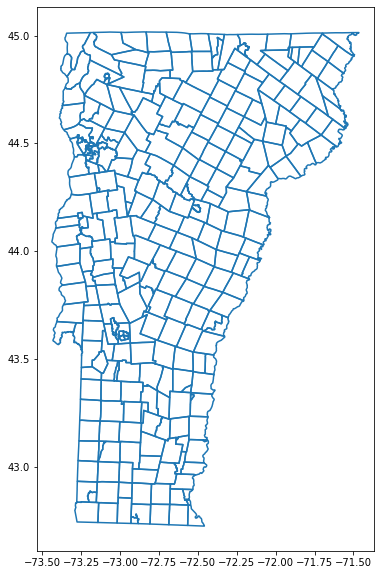

In [46]:
vest_vt_20.boundary.plot(figsize=(10,10))

### Import Census File

In [47]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Vermont"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)


<AxesSubplot:>

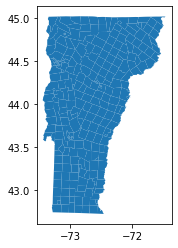

In [48]:
full_shapefiles_census.plot()

In [49]:
state_distr = gp.read_file("./raw-from-source/Shapefiles/VT_Data_-_Vermont_House_Districts_2012/VT_Data_-_Vermont_House_Districts_2012.shp")

#Grab needed columns
state_distr = state_distr[['DISTRICT','NAME','geometry']]

#Modify CRS
state_distr=state_distr.to_crs(vest_vt_20.crs)

county_sub = gp.read_file("./raw-from-source/Shapefiles/VT_2010_Census_County_Subdivision_Boundaries_and_Statistics/VT_2010_Census_County_Subdivision_Boundaries_and_Statistics.shp")

#Grab columns
county_sub = county_sub[['COUNTYFP10','NAME10', 'NAMELSAD10','geometry']]

#Modify CRS
county_sub=county_sub.to_crs(vest_vt_20.crs)

<AxesSubplot:>

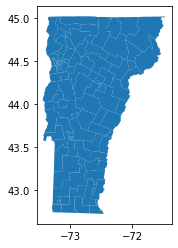

In [50]:
state_distr.plot()

In [51]:
fig = gp.overlay(full_shapefiles_census,state_distr, how="identity")
fig = fig.to_crs(vest_vt_20.crs)
print(fig.shape)

(1246, 18)


<ipython-input-51-1f78c0fec394>:1: UserWarning: `keep_geom_type=True` in overlay resulted in 28 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  fig = gp.overlay(full_shapefiles_census,state_distr, how="identity")


In [52]:
state_distr.columns

Index(['DISTRICT', 'NAME', 'geometry'], dtype='object')

In [53]:
full_shapefiles_census.columns

Index(['STATEFP', 'COUNTYFP', 'VTDST', 'NAMELSAD', 'VTDI', 'LSAD', 'CHNG_TYPE',
       'ORIG_NAME', 'ORIG_CODE', 'RELATE', 'NAME', 'VINTAGE', 'FUNCSTAT',
       'JUSTIFY', 'MTFCC', 'geometry'],
      dtype='object')

### Compare to VEST file

Aside from the handful of merges VEST mentions, these seem to match up

<AxesSubplot:>

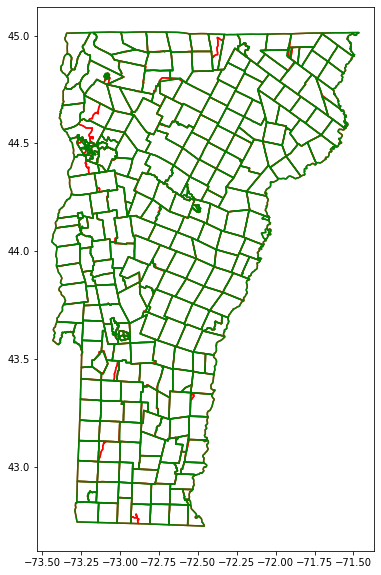

In [54]:
ax_2 = vest_vt_20.boundary.plot(figsize=(10,10),color="red")
full_shapefiles_census.boundary.plot(figsize=(10,10),ax=ax_2,color="green")

<AxesSubplot:>

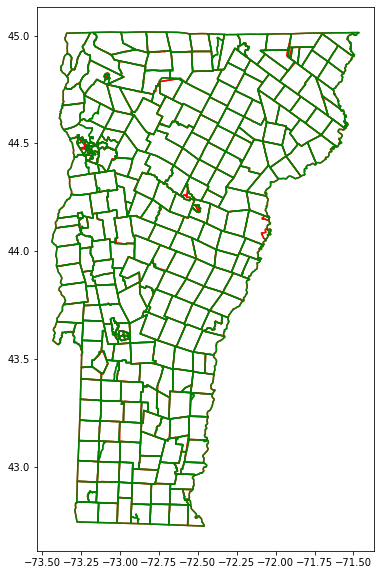

In [55]:
ax_2 = full_shapefiles_census.boundary.plot(figsize=(10,10),color="red")
vest_vt_20.boundary.plot(figsize=(10,10),ax=ax_2,color="green")

## Join Election Results to Shapefile

### Matching Names

In [56]:
full_shapefiles_census = full_shapefiles_census[["COUNTYFP","NAMELSAD","geometry"]]

In [57]:
full_shapefiles_census["NAMELSAD"].value_counts(dropna=False)

Underhill Voting District       1
Winhall Voting District         1
Orwell Voting District          1
Dover Voting District           1
Essex District 1                1
                               ..
Starksboro Voting District      1
Rutland City Ward 3             1
Leicester Voting District       1
West Fairlee Voting District    1
Troy Voting District            1
Name: NAMELSAD, Length: 285, dtype: int64

In [58]:
#Check number of rows and try to find a unique ID for each

print(full_shapefiles_census.shape)

print(len((full_shapefiles_census["NAMELSAD"]).unique()))

(285, 3)
285


In [59]:
full_shapefiles_census["join_col"]=full_shapefiles_census["NAMELSAD"]

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


### Change the names to match (look through dictionary to see typical string differences)

In [60]:
name_changes_dict = {'Addison Voting District':'Addison',
'Albany Voting District':'Albany',
'Alburgh Voting District':'Alburgh',
'Andover Voting District':'Andover',
'Artlington Voting District':'Arlington',
'Athens Voting District':'Athens',
'Averill Voting District':'Averill',
"Avery's Gore Voting District":"Avery's Gore",
'Bakersfield Voting District':'Bakersfield',
'Baltimore Voting District':'Baltimore',
'Barnard Voting District':'Barnard',
'Barnet Voting District':'Barnet',
'Barre Town Voting District':'Barre Town',
'Barton Voting District':'Barton',
'Belvidere Voting District':'Belvidere',
'Bennignton District 1':'Bennington 1',
'Bennington District 2':'Bennington 2',
'Benson Voting District':'Benson',
'Berkshire Voting District':'Berkshire',
'Berlin Voting District':'Berlin',
'Bethel Voting District':'Bethel',
'Bloomfield Voting District':'Bloomfield',
'Bolton Voting District':'Bolton',
'Bradford Voting District':'Bradford',
'Braintree Voting District':'Braintree',
'Brandon Voting District':'Brandon',
'Brattleboro District 1':'Brattleboro 1',
'Brattleboro District 2':'Brattleboro 2',
'Brattleboro District 3':'Brattleboro 3',
'Bridgewater Voting District':'Bridgewater',
'Bridport Voting District':'Bridport',
'Brighton Voting District':'Brighton',
'Bristol Voting District':'Bristol',
'Brookfield Voting District':'Brookfield',
'Brookline Voting District':'Brookline',
'Brownington Voting District':'Brownington',
'Brunswick Voting District':'Brunswick',
"Buel's Gore Voting District":"Buel's Gore",
'Burke Voting District':'Burke',
'Cabot Voting District':'Cabot',
'Calais Voting District':'Calais',
'Cambridge Voting District':'Cambridge',
'Canaan Voting District':'Canaan',
'Castleton Voting District':'Castleton',
'Cavendish Voting District':'Cavendish',
'Charleston Voting District':'Charleston',
'Charlotte Voting District':'Charlotte',
'Chelsea Voting District':'Chelsea',
'Chester Voting District':'Chester',
'Chittenden Voting District':'Chittenden',
'Clarendon Voting District':'Clarendon',
'Concord Voting District':'Concord',
'Corinth Voting District':'Corinth',
'Cornwall Voting District':'Cornwall',
'Coventry Voting District':'Coventry',
'Craftsbury Voting District':'Craftsbury',
'Danby Voting District':'Danby',
'Danville Voting District':'Danville',
'Derby Voting District':'Derby',
'Dorset Voting District':'Dorset',
'Dover Voting District':'Dover',
'Dummerston Voting District':'Dummerston',
'Duxbury Voting District':'Duxbury',
'East Haven Voting District':'East Haven',
'East Montpelier Voting District':'East Montpelier',
'Eden Voting District':'Eden',
'Elmore Voting District':'Elmore',
'Enosburgh Voting District':'Enosburgh',
'Essex District 1':'Essex 1',
'Essex District 2':'Essex 2',
'Essex District 3':'Essex 3',
'Fair Haven Voting District':'Fair Haven',
'Fairfax Voting District':'Fairfax',
'Fairfield Voting District':'Fairfield',
'Fairlee Voting District':'Fairlee',
'Fayston Voting District':'Fayston',
'Ferdinand Voting District':'Ferdinand',
'Ferrisburgh Voting District':'Ferrisburgh',
'Fletcher Voting District':'Fletcher',
'Franklin Voting District':'Franklin',
'Georgia Voting District':'Georgia',
'Glastenbury Voting District':'Glastenbury',
'Glover Voting District':'Glover',
'Goshen Voting District':'Goshen',
'Grafton Voting District':'Grafton',
'Granby Voting District':'Granby',
'Grand Isle Voting District':'Grand Isle',
'Granville Voting District':'Granville',
'Greensboro Voting District':'Greensboro',
'Groton Voting District':'Groton',
'Guildhall Voting District':'Guildhall',
'Guilford Voting District':'Guilford',
'Halifax Voting District':'Halifax',
'Hancock Voting District':'Hancock',
'Hardwick Voting District':'Hardwick',
'Hartford District 1':'Hartford 1',
'Hartford District 2':'Hartford 2',
'Hartland Voting District':'Hartland',
'Highgate Voting District':'Highgate',
'Holland Voting District':'Holland',
'Hubbardton Voting District':'Hubbardton',
'Huntington Voting District':'Huntington',
'Hyde Park Voting District':'Hyde Park',
'Ira Voting District':'Ira',
'Irasburg Voting District':'Irasburg',
'Isle La Motte Voting District':'Isle La Motte',
'Jamacia Voting District':'Jamaica',
'Jay Voting District':'Jay',
'Jericho Voting District':'Jericho',
'Johnson Voting District':'Johnson',
'Killington Voting District':'Killington',
'Kirby Voting District':'Kirby',
'Landgrove Voting District':'Landgrove',
'Leicester Voting District':'Leicester',
'Lemington Voting District':'Lemington',
'Lewis Voting District':'Lewis',
'Lincoln Voting District':'Lincoln',
'Londonderry Voting District':'Londonderry',
'Lowell Voting District':'Lowell',
'Ludlow Voting District':'Ludlow',
'Luneburg Voting District':'Lunenburg',
'Lyndon Voting District':'Lyndon',
'Maidstone Voting District':'Maidstone',
'Manchester Voting District':'Manchester',
'Marlboro Voting District':'Marlboro',
'Marshfield Voting District':'Marshfield',
'Mendon Voting District':'Mendon',
'Middlebury Voting District':'Middlebury',
'Middlesex Voting District':'Middlesex',
'Middletown Springs Voting District':'Middletown Springs',
'Monkton Voting District':'Monkton',
'Montgomery Voting District':'Montgomery',
'Mooretown Voting District':'Moretown',
'Morgan Voting District':'Morgan',
'Morristown Voting District':'Morristown',
'Mount Holly Voting District':'Mount Holly',
'Mount Tabor Voting District':'Mount Tabor',
'New Haven Voting District':'New Haven',
'Newark Voting District':'Newark',
'Newfane Voting District':'Newfane',
'Newport City Voting District':'Newport City',
'Newport Town Voting District':'Newport Town',
'North Hero Voting District':'North Hero',
'Northfield Voting District':'Northfield',
'Norton Voting District':'Norton',
'Norwich Voting District':'Norwich',
'Orange Voting District':'Orange',
'Orwell Voting District':'Orwell',
'Panton Voting District':'Panton',
'Pawlet Voting District':'Pawlet',
'Peacham Voting District':'Peacham',
'Peru Voting District':'Peru',
'Pittsfield Voting District':'Pittsfield',
'Pittsford Voting District':'Pittsford',
'Plainfield Voting District':'Plainfield',
'Plymouth Voting District':'Plymouth',
'Pomfret Voting District':'Pomfret',
'Poultney Voting District':'Poultney',
'Pownal Voting District':'Pownal',
'Proctor Voting District':'Proctor',
'Putney Voting District':'Putney',
'Randolph Voting District':'Randolph',
'Reading Voting District':'Reading',
'Readsboro Voting District':'Readsboro',
'Richford Voting District':'Richford',
'Richmond Voting District':'Richmond',
'Ripton Voting District':'Ripton',
'Rochester Voting District':'Rochester',
'Rockingham Voting District':'Rockingham',
'Roxbury Voting District':'Roxbury',
'Royalton Voting District':'Royalton',
'Rupert Voting District':'Rupert',
'Rutland City Ward 1':'Rutland City 1',
'Rutland City Ward 2':'Rutland City 2',
'Rutland City Ward 3':'Rutland City 3',
'Rutland City Ward 4':'Rutland City 4',
'Rutland Town Voting District':'Rutland Town',
'Ryegate Voting District':'Ryegate',
'Saint George Voting District':'St. George',
'Salisbury Voting District':'Salisbury',
'Sandgate Voting District':'Sandgate',
'Searsburg Voting District':'Searsburg',
'Shaftsbury Voting District':'Shaftsbury',
'Sharon Voting District':'Sharon',
'Sheffield Voting District':'Sheffield',
'Sheldon Voting District':'Sheldon',
'Shoreham Voting District':'Shoreham',
'Shrewsbury Voting District':'Shrewsbury',
'Somerset Voting District':'Somerset',
'South Burlington District 1':'South Burlington 1',
'South Burlington District 2':'South Burlington 2',
'South Burlington District 3':'South Burlington 3',
'South Burlington District 4':'South Burlington 4',
'South Hero Voting District':'South Hero',
'St. Johnsbury Voting District':'St. Johnsbury',
'Stamford Voting District':'Stamford',
'Stannard Voting District':'Stannard',
'Starksboro Voting District':'Starksboro',
'Stockbridge Voting District':'Stockbridge',
'Stowe Voting District':'Stowe',
'Strafford Voting District':'Strafford',
'Stratton Voting District':'Stratton',
'Sudbury Voting District':'Sudbury',
'Sutton Voting District':'Sutton',
'Swanton Voting District':'Swanton',
'Thetford Voting District':'Thetford',
'Topsham Voting District':'Topsham',
'Townshend Voting District':'Townshend',
'Tunbridge Voting District':'Tunbridge',
'Underhill Voting District':'Underhill',
'Vergennes Voting District':'Vergennes',
'Vernon Voting District':'Vernon',
'Vershire Voting District':'Vershire',
'Victory Voting District':'Victory',
'Waitsfield Voting District':'Waitsfield',
'Walden Voting District':'Walden',
'Wallingford Voting District':'Wallingford',
'Waltham Voting District':'Waltham',
'Wardsboro Voting District':'Wardsboro',
"Warner's Grant Voting District":"Warner's Grant",
'Warren Voting District':'Warren',
"Warren's Gore Voting District":"Warren's Gore",
'Washington Voting District':'Washington',
'Waterbury Voting District':'Waterbury',
'Waterford Voting District':'Waterford',
'Waterville Voting District':'Waterville',
'Weathersfield Voting District':'Weathersfield',
'West Fairlee Voting District':'West Fairlee',
'West Haven Voting District':'West Haven',
'West Rutland Voting District':'West Rutland',
'West Windsor Voting District':'West Windsor',
'Westfield Voting District':'Westfield',
'Westford Voting District':'Westford',
'Westmore Voting District':'Westmore',
'Weston Voting District':'Weston',
'Weybridge Voting District':'Weybridge',
'Wheelock Voting District':'Wheelock',
'Whiting Voting District':'Whiting',
'Williamstown Voting District':'Williamstown',
'Williston Voting District':'Williston',
'Wilmington Voting District':'Wilmington',
'Windham Voting District':'Windham',
'Windsor Voting District':'Windsor',
'Winhall Voting District':'Winhall',
'Winooski Voting District':'Winooski',
'Wolcott Voting District':'Wolcott',
'Woodbury Voting District':'Woodbury',
'Woodford Voting District':'Woodford',
'Woodstock Voting District':'Woodstock',
'Worcester Voting District':'Worcester',
"Wells Voting District":"Wells"}

In [61]:
full_shapefiles_census["join_col"] = full_shapefiles_census["join_col"].map(name_changes_dict).fillna(full_shapefiles_census["join_col"])

### Attempt to join

In [62]:
def precinct_merger(precinct_list,new_precinct):
    global full_shapefiles_census
    prec_holder = []
    for i in precinct_list:
        prec_holder.append(full_shapefiles_census.loc[full_shapefiles_census["join_col"]==i])
    new_geom = pd.concat(prec_holder, ignore_index=True).unary_union
    new_prec = gp.GeoDataFrame(geometry=[new_geom],columns=["geometry","join_col"],crs = full_shapefiles_census.crs)
    new_prec["join_col"]=new_precinct
    full_shapefiles_census = full_shapefiles_census.append(new_prec)
    full_shapefiles_census = full_shapefiles_census[~full_shapefiles_census["join_col"].isin(precinct_list)]

In [63]:
precinct_merger(["Barre City Ward 1","Barre City Ward 2","Barre City Ward 3"],"Barre City")
precinct_merger(["Montpelier District 1","Montpelier District 2","Montpelier District 3"],"Montpelier")
precinct_merger(["St. Albans City Ward 1","St. Albans City Ward 2","St. Albans City Ward 3",
                "St. Albans City Ward 4","St. Albans City Ward 5","St. Albans City Ward 6"],"St. Albans City")
precinct_merger(["Newbury Town Voting District","Newbury Village Voting District","Wells River Voting District"],"Newbury")
precinct_merger(["Burlington Ward 1","Burlington Ward 2","Burlington Ward 3",
                "Burlington Ward 4","Burlington Ward 5","Burlington Ward 6",
                "Burlington Ward 7","Burlington Ward 8"],"Burlington-Merged")

In [64]:
source_join = pd.merge(frame,full_shapefiles_census,how="outer",on="join_col",indicator=True)
print(source_join["_merge"].value_counts())

both          255
left_only      29
right_only     12
Name: _merge, dtype: int64


In [65]:
list(source_join[source_join["_merge"]=="left_only"]["join_col"])

['Burlington 1',
 'Burlington 2',
 'Burlington 3',
 'Burlington 4',
 'Burlington 5',
 'Burlington 6',
 'Burlington 7',
 'Colchester 1',
 'Colchester 2',
 'Hinesburg 1',
 'Hinesburg 2',
 'Milton - Chittenden 10',
 'Milton - Grand Isle',
 'Shelburne 1',
 'Shelburne 2',
 'Springfield 1',
 'Springfield 2',
 'St. Albans Town 1',
 'St. Albans Town 2',
 'Sunderland 3',
 'Sunderland 4',
 'Tinmouth - Rutland 2',
 'Tinmouth - Bennington',
 'Troy - Orleans 2',
 'Troy - Lamoille',
 'Westminster 3',
 'Westminster 4',
 'Whitingham - Windham 6',
 'Whitingham - Bennington']

In [66]:
unjoined_shapes_list = source_join[source_join["_merge"]=="right_only"]["join_col"]

In [67]:
print(unjoined_shapes_list)

284         Sunderland Voting District
285          Shelburne Voting District
286          Hinesburg Voting District
287         Colchester Voting District
288             Milton Voting District
289    St. Albans Town Voting District
290               Troy Voting District
291           Tinmouth Voting District
292        Westminster Voting District
293        Whittingham Voting District
294        Springfield Voting District
295                  Burlington-Merged
Name: join_col, dtype: object


In [68]:
print(list(state_distr["NAME"]))

['Addison-1', 'Addison-2', 'Addison-3', 'Addison-4', 'Addison-5', 'Addison Rutland', 'Bennington-1', 'Bennington-2-1', 'Bennington-2-2', 'Bennington-3', 'Bennington-4', 'Bennington-Rutland', 'Caledonia-1', 'Caledonia-2', 'Caledonia-3', 'Caledonia-4', 'Caledonia-Washington', 'Chittenden-1', 'Chittenden-10', 'Chittenden-2', 'Chittenden-3', 'Chittenden-4-1', 'Chittenden-4-2', 'Chittenden-5-1', 'Chittenden-5-2', 'Chittenden-6-1', 'Chittenden-6-2', 'Chittenden-6-3', 'Chittenden-6-4', 'Chittenden-6-5', 'Chittenden-6-6', 'Chittenden-6-7', 'Chittenden-7-1', 'Chittenden-7-2', 'Chittenden-7-3', 'Chittenden-7-4', 'Chittenden-8-1', 'Chittenden-8-2', 'Chittenden-8-3', 'Chittenden-9-1', 'Chittenden-9-2', 'Essex-Caledonia', 'Essex-Caledonia-Orleans', 'Franklin-1', 'Franklin-2', 'Franklin-3-1', 'Franklin-3-2', 'Franklin-4', 'Franklin-5', 'Franklin-6', 'Franklin-7', 'Grand Isle-Chittenden', 'Lamoille-1', 'Lamoille-2', 'Lamoille-3', 'Lamoille-Washington', 'Orange-1', 'Orange-2', 'Orange-Caledonia', 'Ora

In [69]:
#Shapefiles

unjoined_shapes = source_join[source_join["_merge"]=="right_only"]["join_col"]
unjoined_elec = source_join[source_join["_merge"]=="left_only"]["join_col"]

possible_shape_merges = full_shapefiles_census[full_shapefiles_census["join_col"].isin(unjoined_shapes)]
vest_elec_leftovers = vest_vt_20[vest_vt_20["join_col"].isin(unjoined_elec)]



In [70]:
useful_districts_list = ['BEN-3', 'BEN-4', 'WDH-BEN-WDR', 'CHI-2', 'CHI-4-1', 'CHI-4-2',
       'CHI-5-1', 'CHI-5-2', 'CHI-7-1', 'CHI-7-2', 'ADD-4', 'CHI-1',
       'WAS-CHI', 'CHI-10', 'CHI-6-1', 'CHI-6-2', 'CHI-6-7', 'CHI-7-4',
       'CHI-8-1', 'CHI-8-3', 'CHI-9-1', 'CHI-9-2', 'GI-CHI', 'FRA-1',
       'FRA-3-1', 'FRA-3-2', 'FRA-4', 'FRA-6', 'ORL-2', 'ORL-LAM',
       'BEN-RUT', 'RUT-1', 'RUT-2', 'RUT-BEN', 'WDH-3', 'WDH-4', 'WDH-6',
       'WDH-BEN', 'WDR-2', 'WDR-3-1', 'WDR-3-2', 'CHI-6-3', 'CHI-6-4',
       'CHI-6-5', 'CHI-6-6', 'CHI-7-3']

In [71]:
useful_districts = state_distr[state_distr["DISTRICT"].isin(useful_districts_list)]

In [72]:
fig_tst = gp.overlay(possible_shape_merges,useful_districts, how="identity")
fig_tst = fig_tst.to_crs(3857)

<ipython-input-72-216bc9953154>:1: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  fig_tst = gp.overlay(possible_shape_merges,useful_districts, how="identity")


In [73]:
fig_tst["newest-id"] = fig_tst["join_col"]+" | " + fig_tst["DISTRICT"]

In [74]:
fig_tst = fig_tst[~fig_tst["newest-id"].isna()]

In [75]:
fig_tst["area"] = round(fig_tst["geometry"].area,5)

In [76]:
fig_tst = fig_tst[fig_tst["area"]>3000]

In [77]:
full_shapefiles_census.columns

Index(['COUNTYFP', 'NAMELSAD', 'geometry', 'join_col'], dtype='object')

In [78]:
fig_tst = fig_tst[["COUNTYFP","newest-id","geometry","newest-id"]]
fig_tst.columns = ['COUNTYFP', 'NAMELSAD', 'geometry', 'join_col']
fig_tst.reset_index(inplace=True,drop=True)

In [79]:
list(fig_tst["join_col"])

['Sunderland Voting District | BEN-3',
 'Sunderland Voting District | BEN-4',
 'Hinesburg Voting District | CHI-4-1',
 'Hinesburg Voting District | CHI-4-2',
 'Shelburne Voting District | CHI-5-1',
 'Shelburne Voting District | CHI-5-2',
 'Milton Voting District | CHI-10',
 'Burlington-Merged | CHI-6-1',
 'Burlington-Merged | CHI-6-2',
 'Burlington-Merged | CHI-6-7',
 'Colchester Voting District | CHI-9-1',
 'Colchester Voting District | CHI-9-2',
 'Milton Voting District | GI-CHI',
 'St. Albans Town Voting District | FRA-3-1',
 'St. Albans Town Voting District | FRA-3-2',
 'Troy Voting District | ORL-2',
 'Troy Voting District | ORL-LAM',
 'Tinmouth Voting District | RUT-2',
 'Tinmouth Voting District | RUT-BEN',
 'Westminster Voting District | WDH-3',
 'Westminster Voting District | WDH-4',
 'Whittingham Voting District | WDH-6',
 'Whittingham Voting District | WDH-BEN',
 'Springfield Voting District | WDR-3-1',
 'Springfield Voting District | WDR-3-2',
 'Burlington-Merged | CHI-6-3'

In [80]:
full_shapefiles_census = full_shapefiles_census[~full_shapefiles_census["join_col"].isin(unjoined_shapes_list)]
full_shapefiles_census.reset_index(inplace=True,drop=True)

In [81]:
print(fig_tst)

   COUNTYFP                                   NAMELSAD  \
0       003         Sunderland Voting District | BEN-3   
1       003         Sunderland Voting District | BEN-4   
2       007        Hinesburg Voting District | CHI-4-1   
3       007        Hinesburg Voting District | CHI-4-2   
4       007        Shelburne Voting District | CHI-5-1   
5       007        Shelburne Voting District | CHI-5-2   
6       007            Milton Voting District | CHI-10   
7      None                Burlington-Merged | CHI-6-1   
8      None                Burlington-Merged | CHI-6-2   
9      None                Burlington-Merged | CHI-6-7   
10      007       Colchester Voting District | CHI-9-1   
11      007       Colchester Voting District | CHI-9-2   
12      007            Milton Voting District | GI-CHI   
13      011  St. Albans Town Voting District | FRA-3-1   
14      011  St. Albans Town Voting District | FRA-3-2   
15      019               Troy Voting District | ORL-2   
16      019   

In [82]:
fig_tst=fig_tst.to_crs(vest_vt_20.crs)
full_shapefiles_census=full_shapefiles_census.to_crs(vest_vt_20.crs)
final_shapefile = gp.GeoDataFrame(pd.concat([fig_tst,full_shapefiles_census],ignore_index=True),crs=vest_vt_20.crs)

final_shapefile.reset_index(inplace=True,drop=True)

<AxesSubplot:>

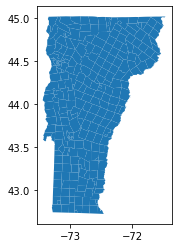

In [83]:
final_shapefile.plot()

In [84]:
final_changes_dict = {'Burlington-Merged | CHI-6-1':'Burlington 1',
 'Burlington-Merged | CHI-6-2':'Burlington 2',
 'Burlington-Merged | CHI-6-3':'Burlington 3',
 'Burlington-Merged | CHI-6-4':'Burlington 4',
 'Burlington-Merged | CHI-6-5':'Burlington 5',
 'Burlington-Merged | CHI-6-6':'Burlington 6',
 'Burlington-Merged | CHI-6-7':'Burlington 7',
 'Colchester Voting District | CHI-9-1':'Colchester 1',
 'Colchester Voting District | CHI-9-2':'Colchester 2',
 'Hinesburg Voting District | CHI-4-1':'Hinesburg 1',
  'Hinesburg Voting District | CHI-4-2':'Hinesburg 2',
 'Milton Voting District | CHI-10':'Milton - Chittenden 10',
 'Milton Voting District | GI-CHI':'Milton - Grand Isle',
 'Shelburne Voting District | CHI-5-1':'Shelburne 1',
 'Shelburne Voting District | CHI-5-2':'Shelburne 2',
 'Springfield Voting District | WDR-3-1':'Springfield 1',
'Springfield Voting District | WDR-3-2':'Springfield 2',
 'St. Albans Town Voting District | FRA-3-1':'St. Albans Town 1',
 'St. Albans Town Voting District | FRA-3-2':'St. Albans Town 2',
 'Sunderland Voting District | BEN-3':'Sunderland 3',
 'Sunderland Voting District | BEN-4':'Sunderland 4',
 'Tinmouth Voting District | RUT-2':'Tinmouth - Rutland 2',
 'Tinmouth Voting District | RUT-BEN':'Tinmouth - Bennington',
 'Troy Voting District | ORL-2':'Troy - Orleans 2',
 'Troy Voting District | ORL-LAM':'Troy - Lamoille',
 'Westminster Voting District | WDH-3':'Westminster 3',
 'Westminster Voting District | WDH-4':'Westminster 4',
 'Whittingham Voting District | WDH-6':'Whitingham - Windham 6',
 'Whittingham Voting District | WDH-BEN':'Whitingham - Bennington'}

In [85]:
final_shapefile["join_col"] = final_shapefile["join_col"].map(final_changes_dict).fillna(final_shapefile["join_col"])

<AxesSubplot:>

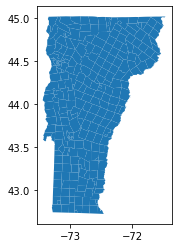

In [86]:
final_shapefile.plot()

In [87]:
source_join = pd.merge(frame,final_shapefile,how="outer",on="join_col",indicator=True)
source_join["_merge"].value_counts()

both          284
left_only       0
right_only      0
Name: _merge, dtype: int64

In [88]:
print(source_join[source_join["COUNTYFP"].isna()])

              NAME20        NAME20_1  G20TREDPEA  G20TRERBRA  G20TREIWRI  \
10        Barre City                        2324        1066         160   
37        Burlington  Chittenden 6-1        3237         924         311   
38        Burlington  Chittenden 6-2        1972         384         137   
39        Burlington  Chittenden 6-3        2937         335         248   
40        Burlington  Chittenden 6-4        1962         225         111   
41        Burlington  Chittenden 6-5        3882         549         207   
42        Burlington  Chittenden 6-6         937         131          49   
43        Burlington  Chittenden 6-7         230          47          23   
140       Montpelier                        4071         508         109   
148          Newbury                         616         443          55   
206  St. Albans City                        1341        1305         168   

     G20TREPERI  G20TREOWRI  G20ATGDDON  G20ATGRPAI  G20ATGPERI  ...  \
10          110

In [96]:
source_join.loc[source_join["join_col"]=="Barre City","COUNTYFP"]="023"
source_join.loc[source_join["join_col"]=="Burlington 1","COUNTYFP"]="007"
source_join.loc[source_join["join_col"]=="Burlington 2","COUNTYFP"]="007"
source_join.loc[source_join["join_col"]=="Burlington 3","COUNTYFP"]="007"
source_join.loc[source_join["join_col"]=="Burlington 4","COUNTYFP"]="007"
source_join.loc[source_join["join_col"]=="Burlington 5","COUNTYFP"]="007"
source_join.loc[source_join["join_col"]=="Burlington 6","COUNTYFP"]="007"
source_join.loc[source_join["join_col"]=="Burlington 7","COUNTYFP"]="007"
source_join.loc[source_join["join_col"]=="Montpelier","COUNTYFP"]="023"
source_join.loc[source_join["join_col"]=="Newbury","COUNTYFP"]="017"
source_join.loc[source_join["join_col"]=="St. Albans City","COUNTYFP"]="011"


In [ ]:
"":"Washington"
Burlington 1:Chittenden
    Montpelier:Washington
        Newbury:Orange
      St. Albans City:Franklin      

In [98]:
vest_vt_20

,STATEFP20,COUNTYFP20,NAME20,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREGHAW,G20PREIWES,G20PREOOTH,G20PREOSAN,...,G20TREDPEA,G20TRERBRA,G20TREPERI,G20TREIWRI,G20TREOWRI,G20AUDOHOF,G20AUDPERI,G20AUDOWRI,geometry,join_col
0,50,001,Whiting,124,84,1,0,0,7,1,...,102,83,7,13,0,161,22,1,"POLYGON ((-73.24173 43.90482, -73.23971 43.905...",Whiting
1,50,001,New Haven,732,396,12,1,4,17,0,...,637,404,36,47,2,927,121,10,"POLYGON ((-73.24958 44.08834, -73.24947 44.089...",New Haven
2,50,001,Salisbury,393,258,8,0,1,13,2,...,343,245,13,36,0,498,94,2,"POLYGON ((-73.18875 43.89438, -73.18870 43.894...",Salisbury
3,50,001,Orwell,367,351,7,3,2,18,1,...,315,337,18,48,0,570,92,2,"POLYGON ((-73.39280 43.82277, -73.39256 43.823...",Orwell
4,50,001,Ferrisburgh,1202,561,22,9,4,15,6,...,1034,592,59,68,0,1452,189,4,"POLYGON ((-73.40066 44.15341, -73.40029 44.154...",Ferrisburgh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,50,019,Troy - Orleans 2,98,115,5,0,1,3,1,...,100,98,3,15,0,170,32,0,"POLYGON ((-72.33753 44.97267, -72.33981 44.963...",Troy - Orleans 2
280,50,025,Westminster 4,1244,403,11,12,5,17,5,...,1004,387,139,65,0,1069,368,9,"POLYGON ((-72.58564 43.02324, -72.58491 43.027...",Westminster 4
281,50,025,Westminster 3,59,26,2,2,2,0,0,...,45,28,9,7,0,59,23,0,"MULTIPOLYGON (((-72.47096 43.12585, -72.46566 ...",Westminster 3
282,50,025,Whitingham - Windham 6,372,319,21,2,1,10,0,...,293,307,26,41,1,465,119,4,"POLYGON ((-72.92891 42.76771, -72.92890 42.767...",Whitingham - Windham 6


In [99]:
diff_counties=[]
print("Counties with differences will be printed below:")
for i in data_columns:
    diff = source_join.groupby(["COUNTYFP"]).sum()[i]-vest_vt_20.groupby(["COUNTYFP20"]).sum()[i]
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(diff[diff != 0].to_string(header=False))
print("")
print("All other races in all counties are equal")

Counties with differences will be printed below:

All other races in all counties are equal


## Join Source File to VEST File

In [90]:
final_merge = pd.merge(vest_vt_20,source_join,how="outer",on="join_col",indicator="final_merge")
final_merge["final_merge"].value_counts()

both          284
left_only       0
right_only      0
Name: final_merge, dtype: int64

## Validate Geometry

In [93]:
print(final_merge.columns)

Index(['STATEFP20', 'COUNTYFP20', 'NAME20_x', 'G20PREDBID_x', 'G20PRERTRU_x',
       'G20PRELJOR_x', 'G20PREGHAW_x', 'G20PREIWES_x', 'G20PREOOTH_x',
       'G20PREOSAN_x',
       ...
       'G20SOSDCON_y', 'G20SOSRPAI_y', 'G20SOSISMI_y', 'G20SOSPERI_y',
       'G20SOSOWRI_y', 'COUNTYFP', 'NAMELSAD', 'geometry_y', '_merge',
       'final_merge'],
      dtype='object', length=108)


In [94]:
both = final_merge[final_merge["final_merge"]=="both"]
vest_geoms = gp.GeoDataFrame(both,geometry="geometry_x",crs=vest_vt_20.crs)
source_geoms = gp.GeoDataFrame(both,geometry="geometry_y",crs=vest_vt_20.crs)
source_geoms = source_geoms.to_crs(3857)
vest_geoms = vest_geoms.to_crs(3857)
source_geoms["geometry_x"]=source_geoms.buffer(0)
vest_geoms["geometry_y"]=vest_geoms.buffer(0)
vals = source_geoms.geom_almost_equals(vest_geoms,decimal=0)
print(vals.value_counts())

False    273
True      11
dtype: int64


1) For New Haven difference in area is 0.17962353530110742
2) For Salisbury difference in area is 0.1719120588172598
3) For Ripton difference in area is 0.5887607196199548
4) For Bristol difference in area is 0.4770118657629877
5) For Monkton difference in area is 0.11162699457280377
6) For Lincoln difference in area is 0.6027235036287731
7) For Waltham difference in area is 0.11507957676099967
8) For Hancock difference in area is 0.2975766555152982
9) For Somerset difference in area is 0.3273420340277166
10) For Stratton difference in area is 0.3976629426891354
11) For Winhall difference in area is 0.33384665848990247
12) For Peru difference in area is 0.13069959321393526
13) For Middlebury difference in area is 0.3023947459749568
14) For Starksboro difference in area is 0.2847994586847476
15) For Bridport difference in area is 0.1163148988850203
16) For Granville difference in area is 0.3050750089133354
17) For Shoreham difference in area is 0.16253902011051832
18) For Cornwall diffe

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/plotting.py:384: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


24) For Wilmington difference in area is 0.16858748645362026
25) For Grafton difference in area is 0.31655530231755974
26) For Windham difference in area is 0.209988661734627
27) For Marlboro difference in area is 0.21450937279495894
28) For Londonderry difference in area is 0.1823808954185749
29) For Dover difference in area is 0.38804124393932615
30) For Jamaica difference in area is 0.21084752906011506
31) For Newfane difference in area is 0.14592013021105205
32) For Brookline difference in area is 0.1357988659512043
33) For Athens difference in area is 0.6391603754979398
34) For Bennington 1 difference in area is 0.14997340567108694
35) For Arlington difference in area is 0.15324176292201822
36) For Landgrove difference in area is 0.14306783406392262
37) For Wardsboro difference in area is 0.10305511031054265
38) For Sandgate difference in area is 0.15609149879292616
39) For Manchester difference in area is 0.27595069485800117
40) For Pownal difference in area is 0.1428600595018168

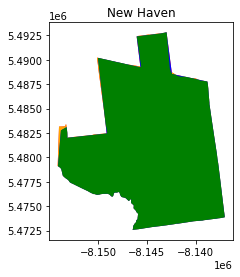

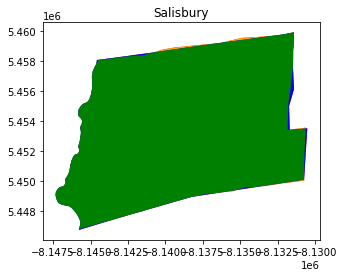

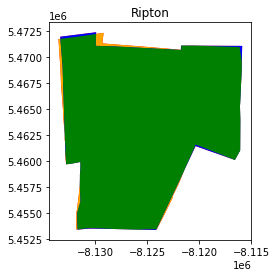

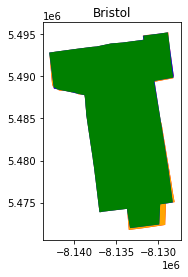

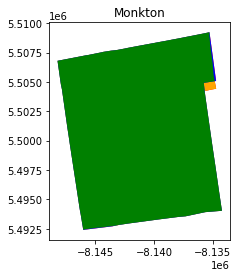

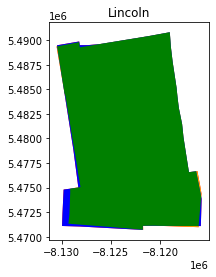

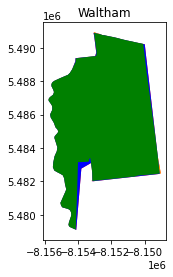

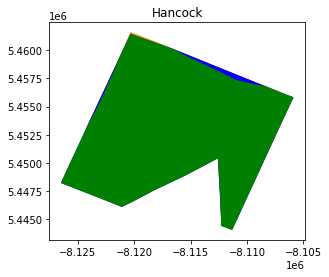

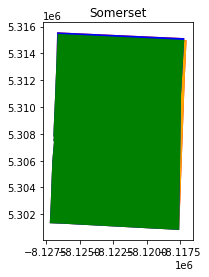

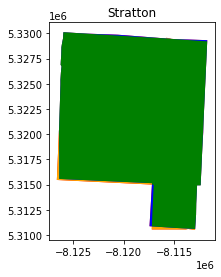

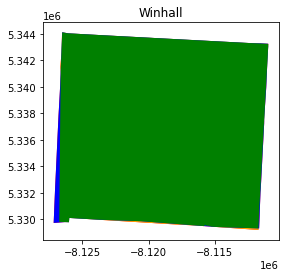

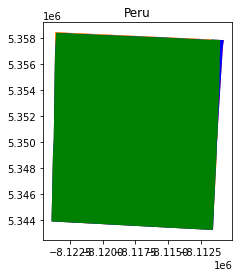

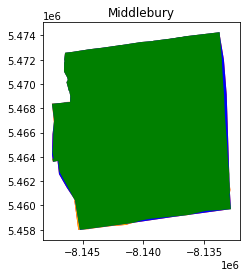

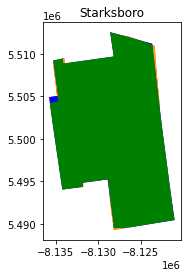

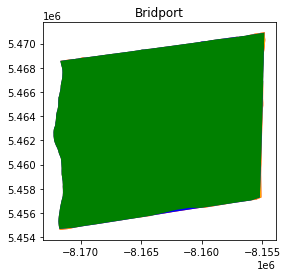

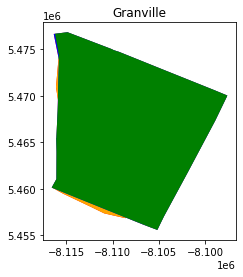

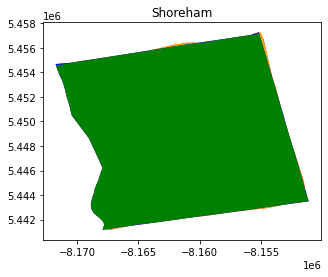

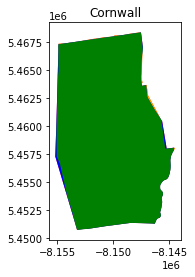

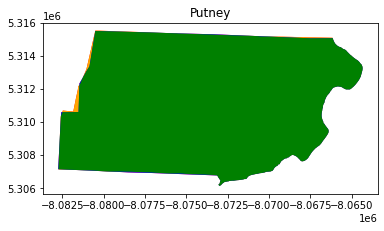

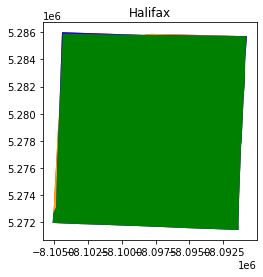

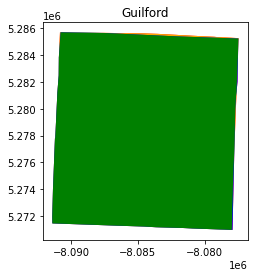

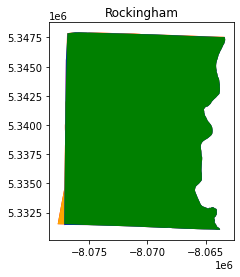

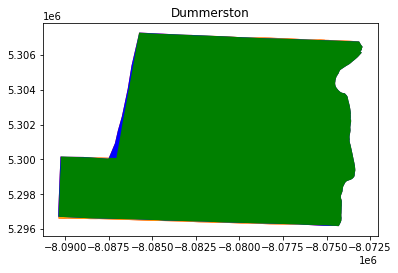

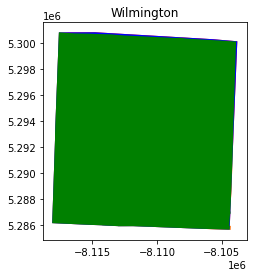

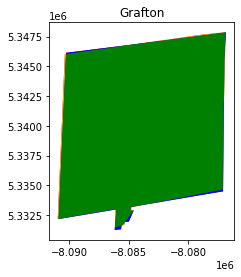

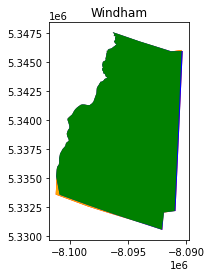

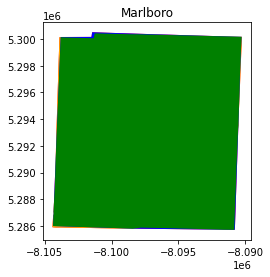

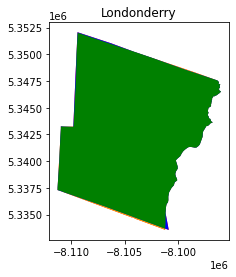

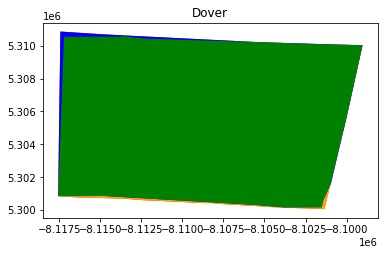

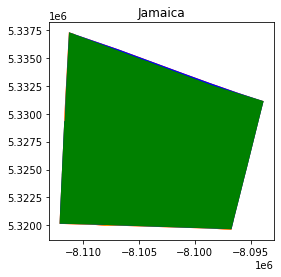

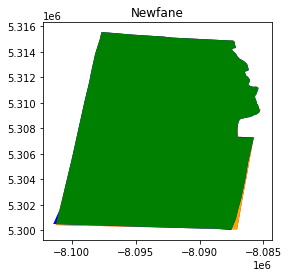

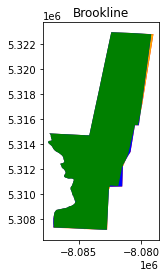

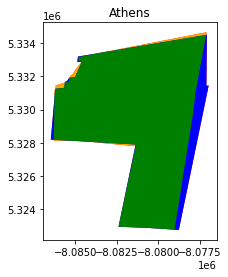

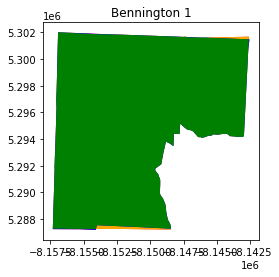

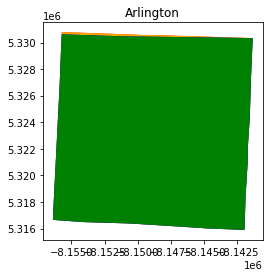

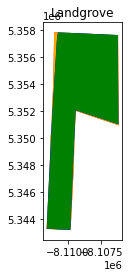

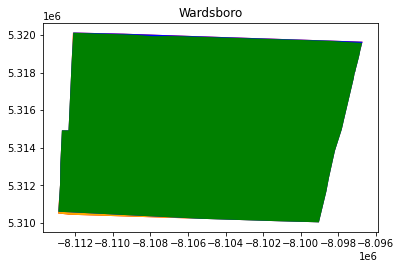

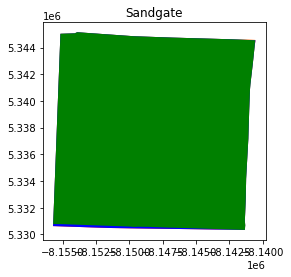

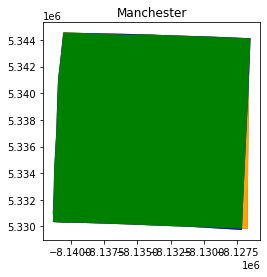

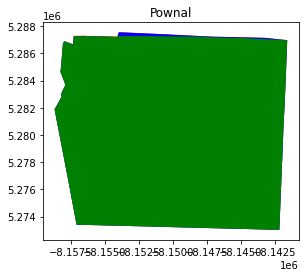

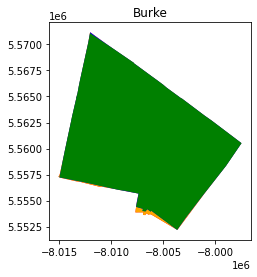

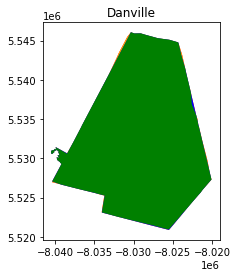

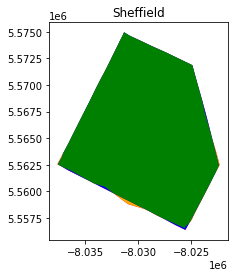

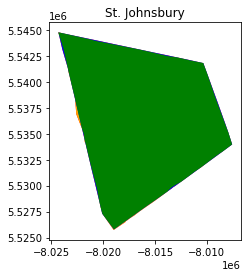

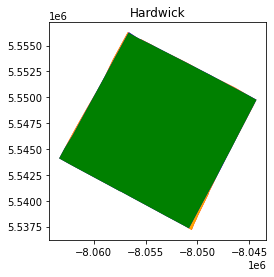

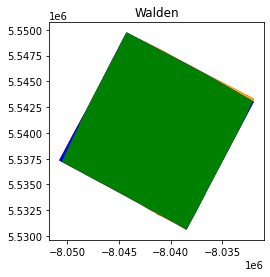

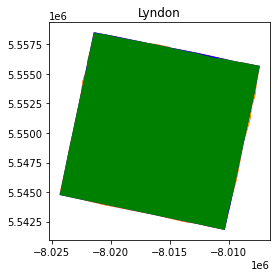

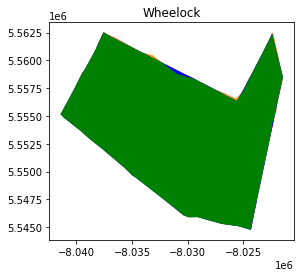

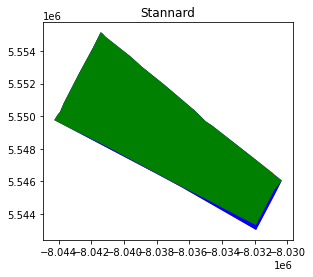

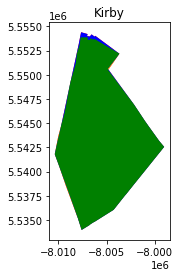

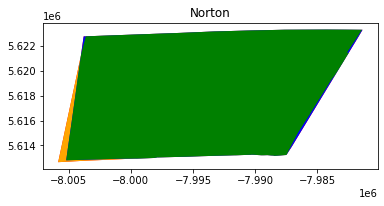

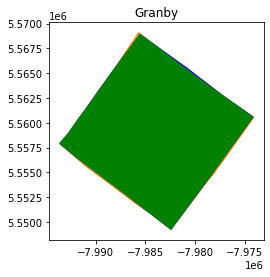

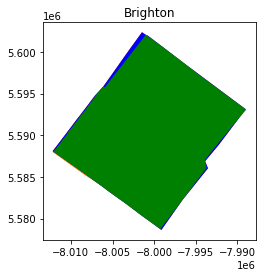

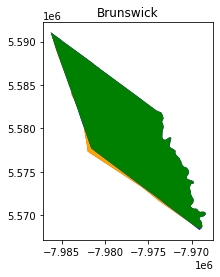

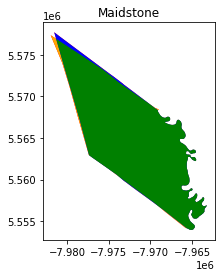

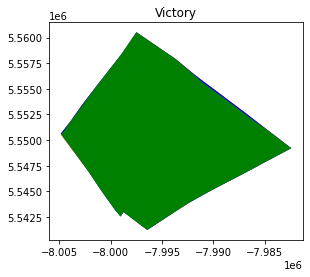

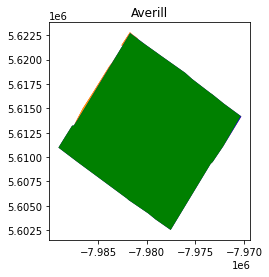

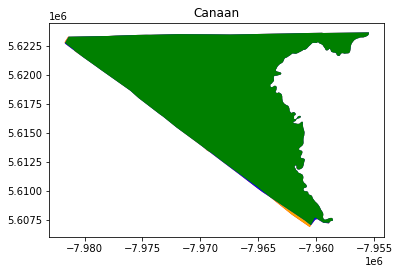

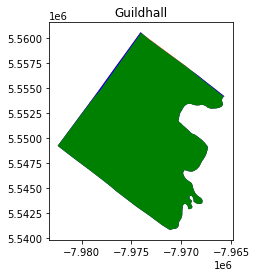

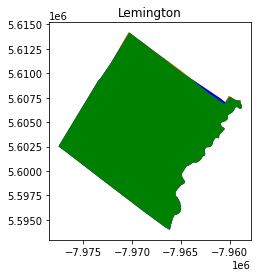

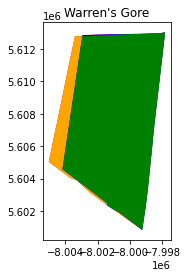

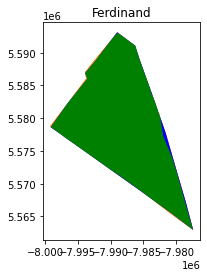

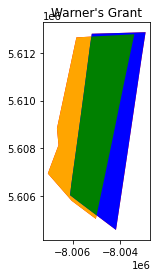

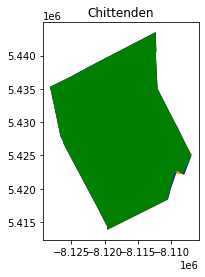

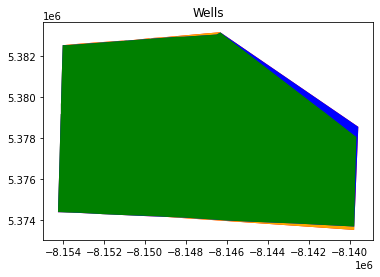

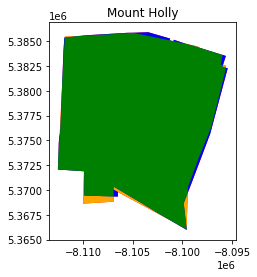

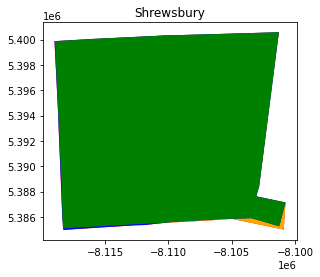

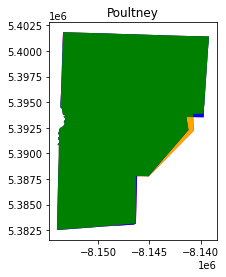

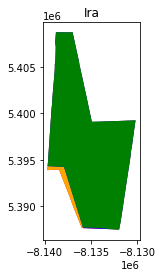

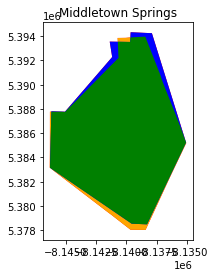

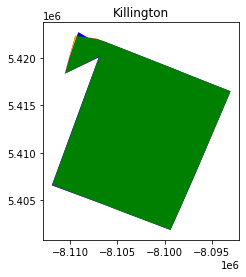

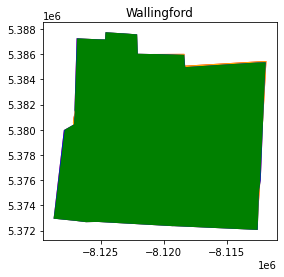

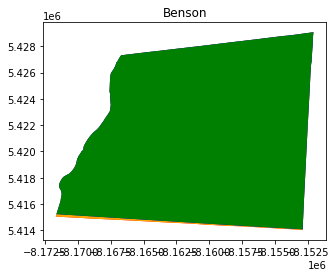

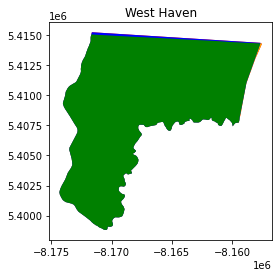

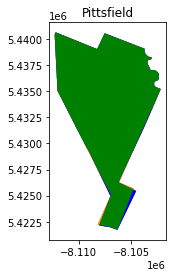

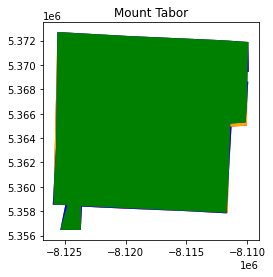

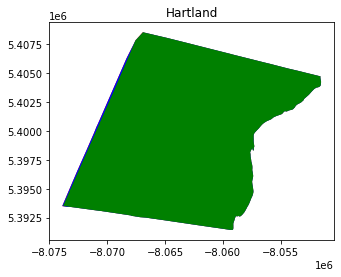

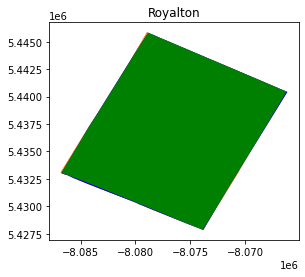

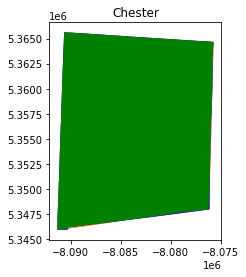

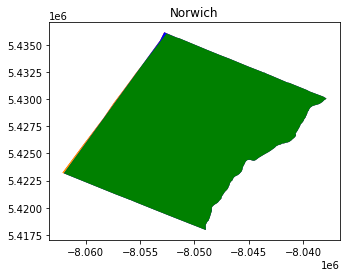

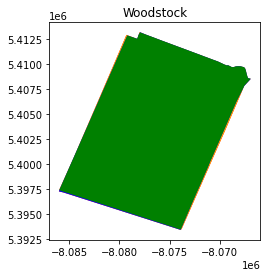

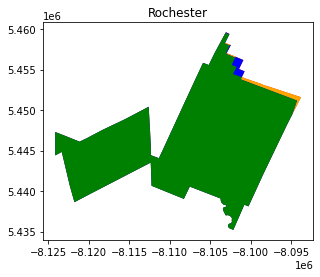

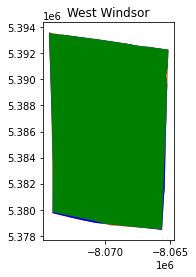

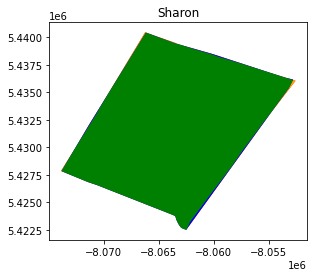

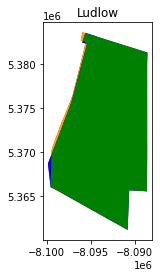

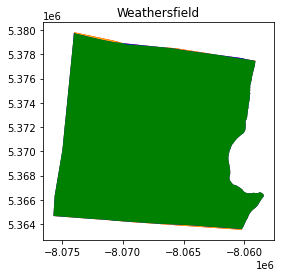

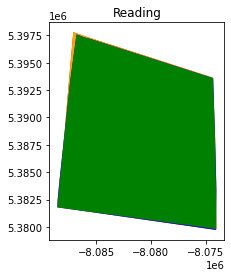

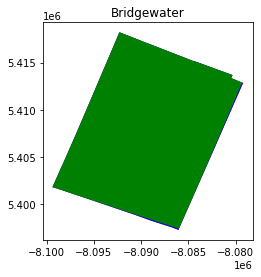

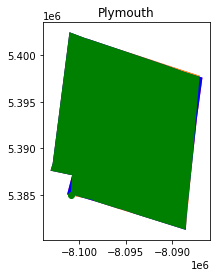

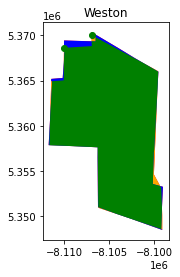

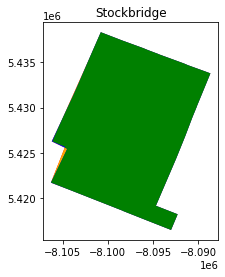

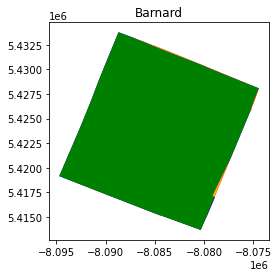

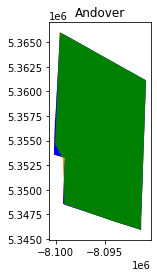

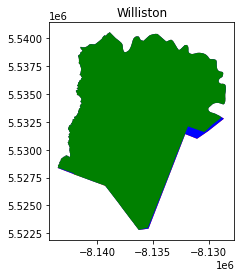

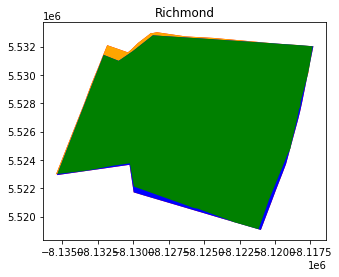

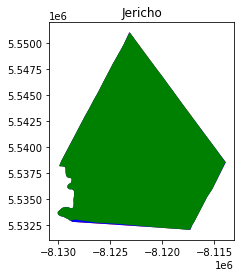

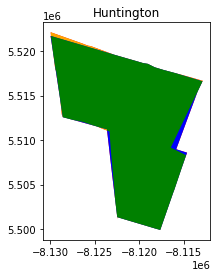

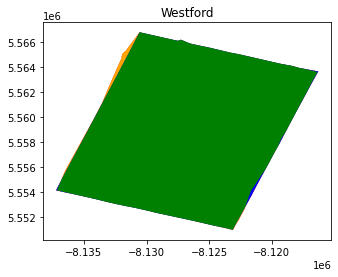

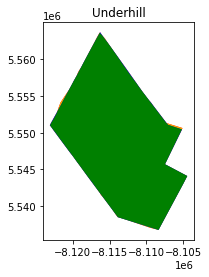

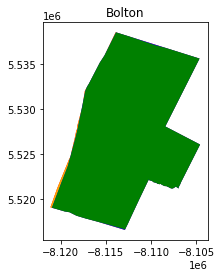

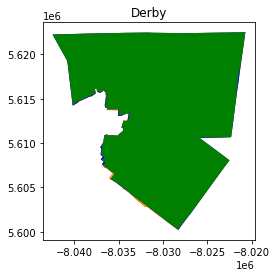

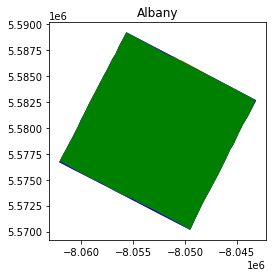

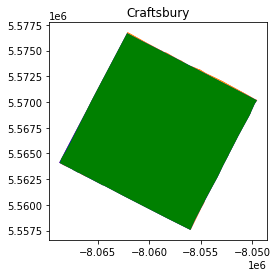

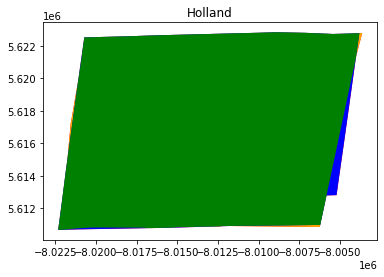

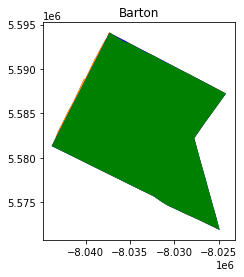

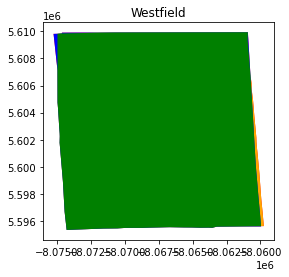

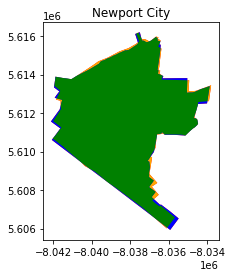

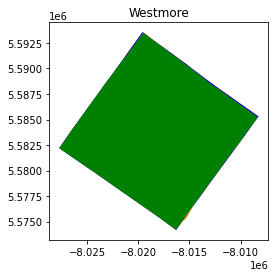

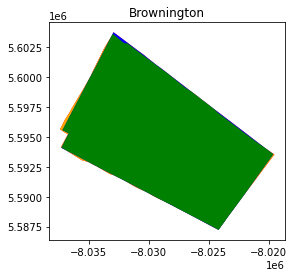

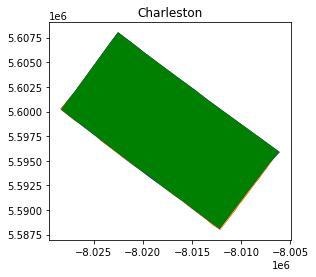

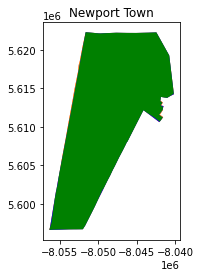

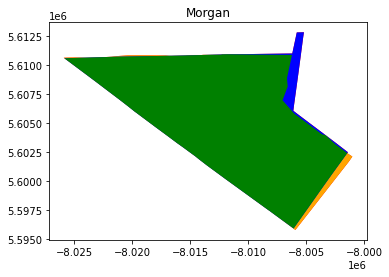

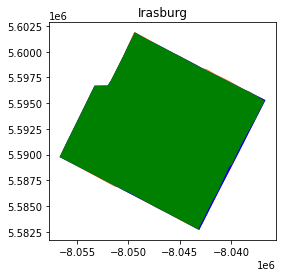

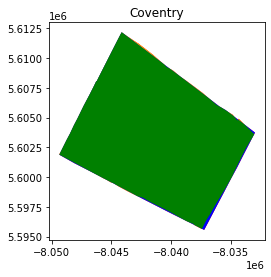

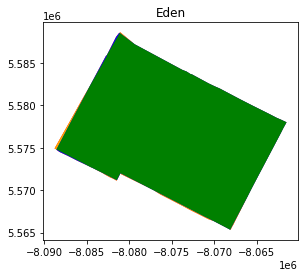

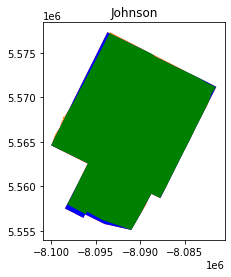

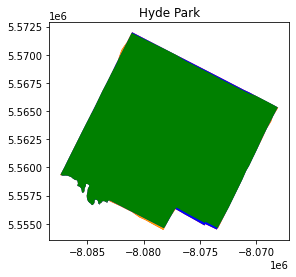

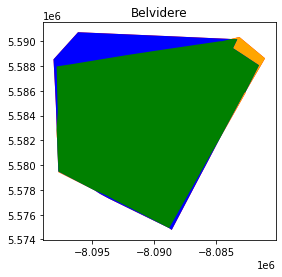

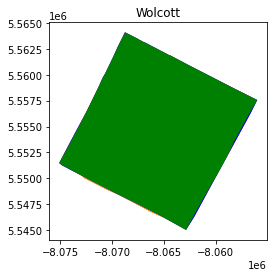

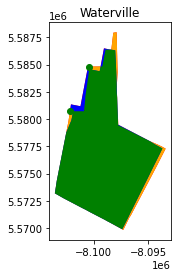

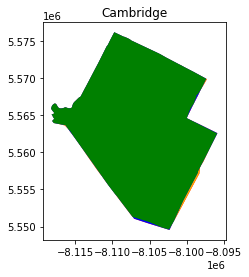

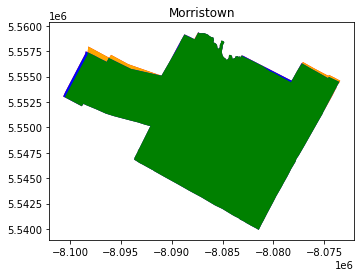

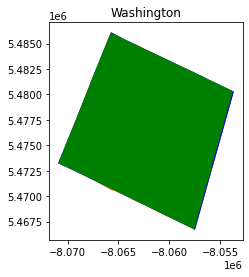

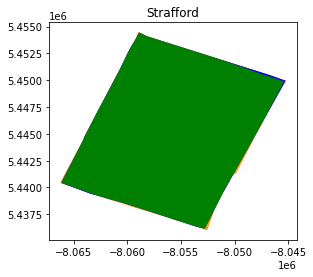

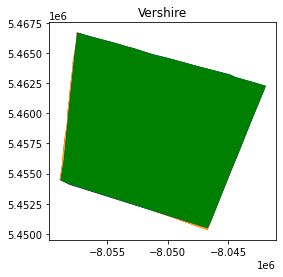

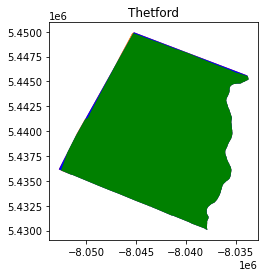

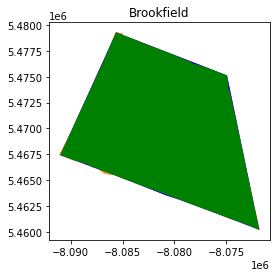

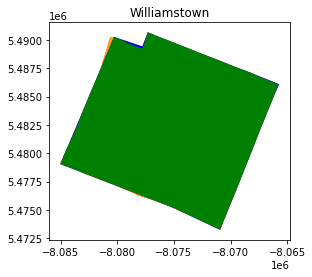

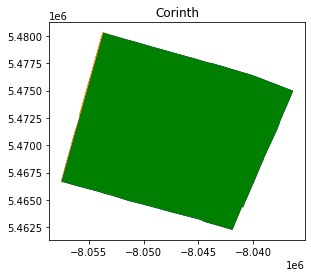

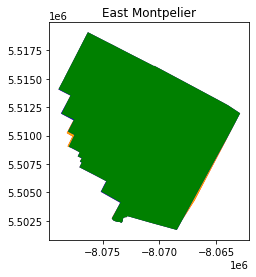

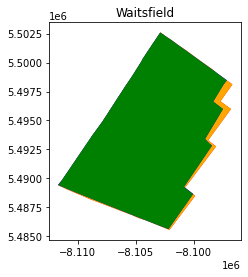

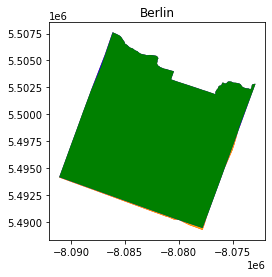

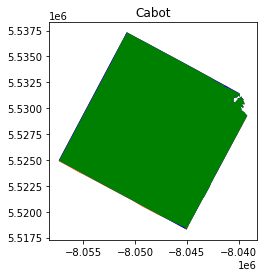

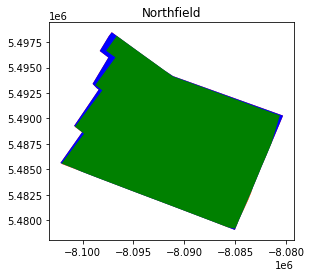

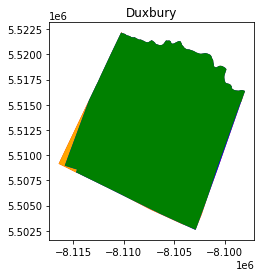

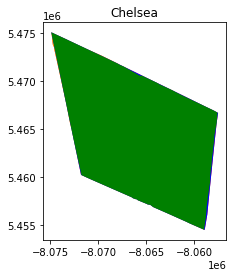

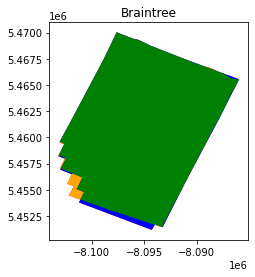

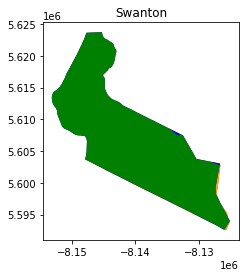

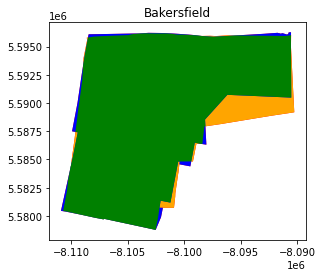

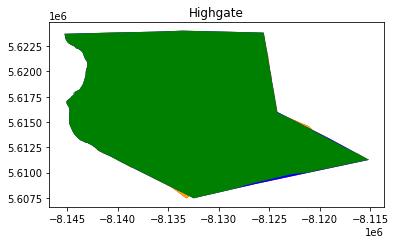

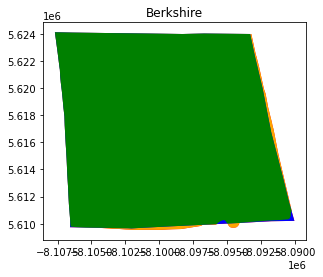

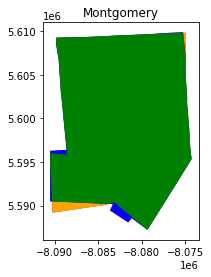

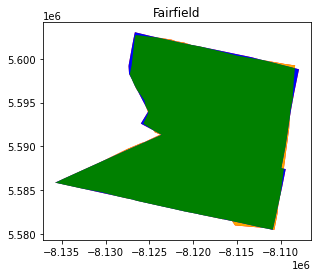

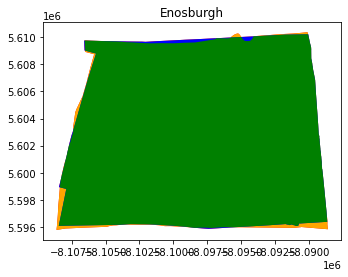

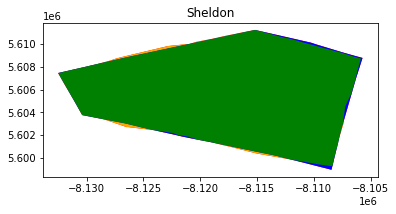

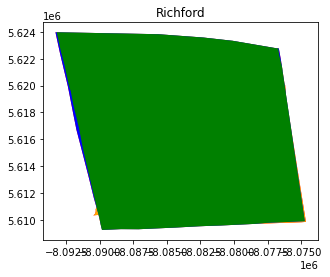

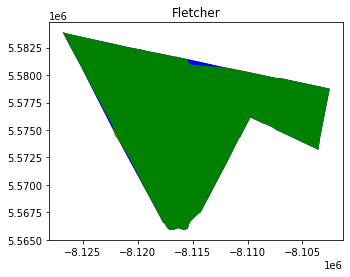

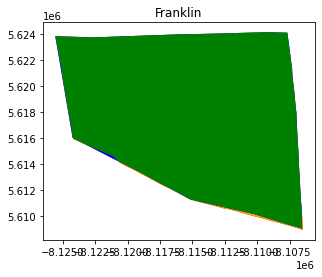

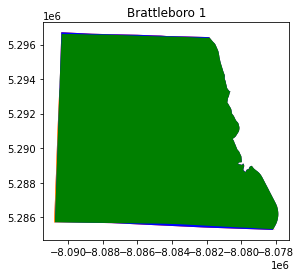

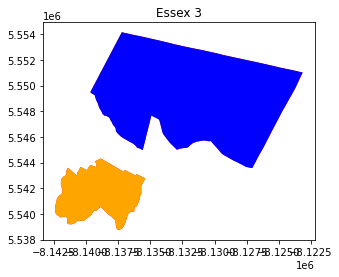

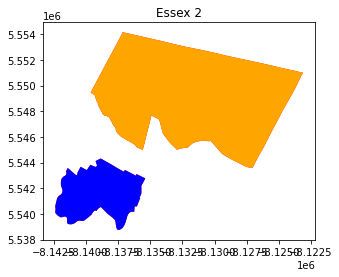

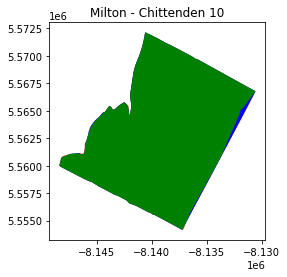

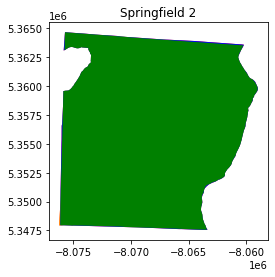

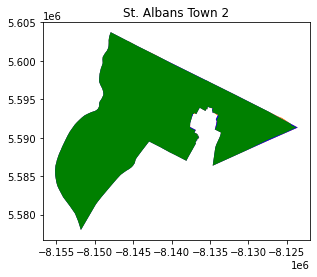

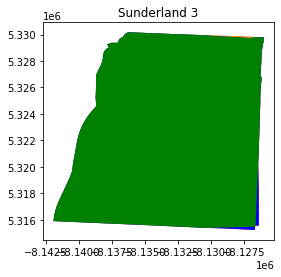

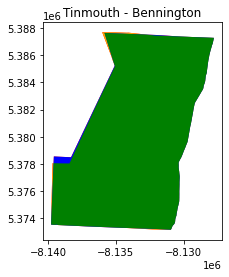

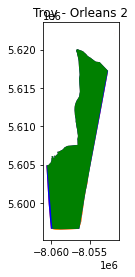

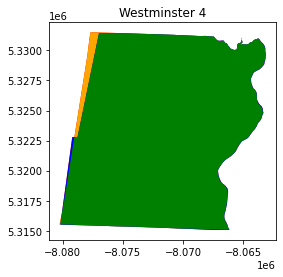

In [95]:
count = 0
area_list = []
for i in range(0,len(source_geoms)):
    diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])
    intersection = source_geoms.iloc[[i]].intersection(vest_geoms.iloc[[i]])
    area = float(diff.area/10e6)
    area_list.append(area)
    #print("Area is " + str(area))

    if (area > .1):
        count += 1
        name = source_geoms.iat[i,2]
        
        print(str(count)+") For " + name + " difference in area is " + str(area))
        if (intersection.iloc[0].is_empty):
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            base.set_title(name)
        else:
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            intersection.plot(color="green",ax=base)
            base.set_title(name)

<AxesSubplot:>

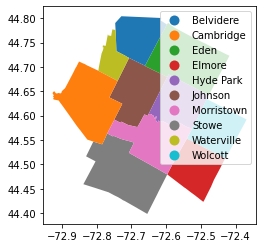

In [114]:
vest_vt_20[vest_vt_20["COUNTYFP20"]=="015"].plot(column="NAME20",legend=True)

<AxesSubplot:>

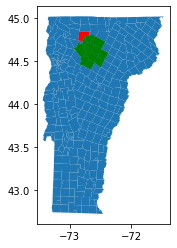

In [108]:
ax = final_shapefile.plot()
final_shapefile[final_shapefile["join_col"]=="Bakersfield"].plot(color="red",ax=ax)
final_shapefile[final_shapefile["COUNTYFP"]=="015"].plot(color="green",ax=ax)

In [ ]:
vest_vt_20[vest_vt_20["join_col"]=="Wells"].plot()

In [ ]:
#Essex 3 and Essex 2, Wells

In [ ]:
df = pd.DataFrame(area_list)
print(df.shape)

print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")